<script>
  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
  (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
  m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
  })(window,document,'script','//www.google-analytics.com/analytics.js','ga');

  ga('create', 'UA-142140-8', 'jiahao.github.io');
  ga('require', 'displayfeatures');
  ga('send', 'pageview');

</script>


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a> _Copyright &copy; 2014-6 <a xmlns:cc="http://creativecommons.org/ns#" href="http://jiahao.github.io/julia-blog/2014/06/09/the-colors-of-chemistry.html" property="cc:attributionName" rel="cc:attributionURL">Jiahao Chen</a> (jiahao@mit.edu), Research Scientist at [MIT CSAIL](http://csail.mit.edu).
<span xmlns:dct="http://purl.org/dc/terms/" property="dct:title"><b>The Colors of Chemistry</b></span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Follow the discussion [on Hacker News](https://news.ycombinator.com/item?id=7870138)
, or get this IJulia notebook [on Github](https://github.com/jiahao/ijulia-notebooks)_.

# The colors of chemistry

This notebook documents my exploration of color theory and its applications to photochemistry. It also shows off the functionality of several Julia packages: [Color.jl](http://github.com/JuliaLang/Color.jl) for color theory and colorimetry, [SIUnits.jl](http://github.com/Keno/SIUnits.jl) for unitful computations, and [Gadfly.jl](http://github.com/dcjones/Gadfly.jl) for graph plotting.

In [1]:
using Colors, Gadfly, SIUnits, SIUnits.ShortUnits

    /(Number, SIUnits.SIQuantity{#T<:Any, m<:Any, kg<:Any, s<:Any, A<:Any, K<:Any, mol<:Any, cd<:Any, rad<:Any, sr<:Any}) at /Users/jiahao/.julia/v0.4/SIUnits/src/SIUnits.jl:156
is ambiguous with: 
    /(DualNumbers.Dual, Number) at /Users/jiahao/.julia/v0.4/DualNumbers/src/dual.jl:230.
To fix, define 
    /(DualNumbers.Dual, SIUnits.SIQuantity{#T<:Any, m<:Any, kg<:Any, s<:Any, A<:Any, K<:Any, mol<:Any, cd<:Any, rad<:Any, sr<:Any})
before the new definition.
    /(Number, SIUnits.SIUnit) at /Users/jiahao/.julia/v0.4/SIUnits/src/SIUnits.jl:169
is ambiguous with: 
    /(DualNumbers.Dual, Number) at /Users/jiahao/.julia/v0.4/DualNumbers/src/dual.jl:230.
To fix, define 
    /(DualNumbers.Dual, SIUnits.SIUnit)
before the new definition.


Note: Some versions of these packages may throw ambiguity warnings. They are harmless for the purpose of running this notebook and can be ignored.

## Color vision and the visible spectrum

Physically speaking, light is radiation in the form of electromagnetic waves, and can therefore be quantified by certain characteristics such as wavelength and amplitude. Color theory studies how such characteristics get translated into a sensory perception, that of color.

The human eye supports two types of vision: [photoptic vision](http://en.wikipedia.org/wiki/Photopic_vision) occurs under bright light, and [scotopic vision](http://en.wikipedia.org/wiki/Scotopic_vision) occurs under dim light. These two modes come from using different types of vision cells, namely cones and rods respectively. Only cones sense color, and are sensitive to light with wavelengths in the range of 350-800 nm. The actual range can vary from person to person.

[Color theory](http://en.wikipedia.org/wiki/Color_theory) focuses mainly on photoptic vision in the 380-780 nm region. Computations for color theory are provided by functions in the Julia package `Colors.jl`. For example, `colormatch` calculates the perceived color produced by monochromatic light, i.e. light waves of a single, pure wavelength.

In [2]:
colormatch(532) #Frequency-doubled Nd:YAG laser

In [3]:
#Define custom type to plot nicely with rainbow-like swatch
type ColorVector{T<:Colorant} <: AbstractVector{T}
    C :: Vector{T}
end
import Base: size, writemime
size(C::ColorVector) = size(C.C)

function writemime(io::IO, ::MIME"image/svg+xml", cs::ColorVector)
    n = length(cs.C)
    width=0.5
    pad=0
    write(io, """
        <?xml version="1.0" encoding="UTF-8"?>
        <!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
         "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
        <svg xmlns="http://www.w3.org/2000/svg" version="1.1"
             width="$(n*width)mm" height="25mm"
             shape-rendering="crispEdges">
        """)
    for (i, c) in enumerate(cs.C)
        write(io,
            """
            <rect x="$((i-1)*width)mm" width="$(width - pad)mm" height="100%"
                  fill="#$(hex(c))" stroke="none" />
            """)
    end
    write(io, "</svg>")
end

λrange = 380:1.5:780
rainbow = ColorVector(Colorant[colormatch(λ) for λ in λrange])

## Raw light power and the XYZ color space

The modern foundations of color theory can be traced back to the [CIE 1931 color space](http://en.wikipedia.org/wiki/CIE_1931_color_space) model. Building upon centuries of empirical evidence that three coordinates are sufficient to quantify perceived colors, the CIE model defines three basis functions $\overline{x}(\lambda)$, $\overline{y}(\lambda)$ and $\overline{z}(\lambda)$ over (most of) the visible wavelength range  380nm $\le\lambda\le$780 nm.

These basis functions define a linear vector space known as the XYZ color space. An arbitrary function $f(\lambda)$ has a three-dimensional projection as a vector in this vector space, with components known as _tristimulus values_ that are given by the projections

$$ X = \int f(\lambda) \overline{x}(\lambda) d\lambda $$
$$ Y = \int f(\lambda) \overline{y}(\lambda) d\lambda $$
$$ Z = \int f(\lambda) \overline{z}(\lambda) d\lambda $$

The CIE standard defines the basis functions in discrete tabular form; the raw data for $\overline{x}(\lambda)$, $\overline{y}(\lambda)$ and $\overline{z}(\lambda)$ are available in `Color.cie1931_cmf_table[:,i] for i=1:3` respectively.

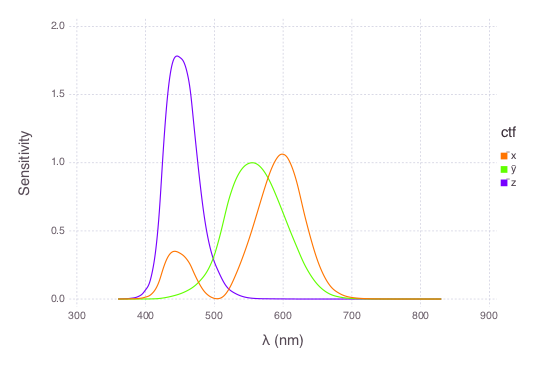

In [4]:
#Creates a plot layer for each color transfer function (ctf)
ctf_layer(i)=layer(Geom.line,
  x=360:830, y=Colors.cie1931_cmf_table[:,i],
  color=fill(string('x'+i-1, '̄'), 471), #Generate name of ctf
)

[ctf_layer(i) for i=1:3]

#Plot the X, Y and Z ctfs
plot(Guide.XLabel("λ (nm)"), Guide.YLabel("Sensitivity"),
  Guide.colorkey("ctf"),
  #color each ctf by wavelength of peak sensitivity
  Scale.color_discrete_manual( 
    map(colormatch, 359.+
  [indmax(Colors.cie1931_cmf_table[:,i]) for i=1:3])...),
  [ctf_layer(i) for i=1:3]...,
)

### Computing white

As a sanity check, I wanted to make sure that projecting a flat power spectrum into the XYZ space produced a white color. This is white in the purely technical sense, of having the same intensity of light at every wavelength.

To do this, we'll have to imbue the XYZ color space with vector space operations; in particular, we want to add and scale vectors. It follows by the definition of the XYZ color space that the usual notions of these operations apply (the color space has no curvature). These operations are not currently in `Color.jl`, but Julia makes it very easy to extend:

In [5]:
import Base:+, *
#The XYZ color space is a linear vector space
#So these operations make sense!
+(a::XYZ, b::XYZ) = XYZ(a.x+b.x,a.y+b.y,a.z+b.z)
*(a::Real,c::XYZ) = XYZ(a*c.x,  a*c.y,  a*c.z)

* (generic function with 213 methods)

With these two operations defined, we can now proceed to compute the projections, which are convolutions against the basis functions.

In [6]:
@show mapreduce(colormatch, +, 380:780)

mapreduce(colormatch,+,380:780) = XYZ{Float64}(106.85508530329987,106.85642627788003,106.84608243163598)

Ok, this looks like white. However, there's some built-in assumption on the normalization in `Colors.jl` which I haven't figured out yet, which means that any `XYZ(X,Y,Z)` for sufficiently positive `(X,Y,Z)` will render as white.

The easy solution to this is to convert to the xyY color space, where $x$ and $y$ are (normalized) _chromaticity coordinates_ (such that $x+y+z=1$) and $Y$ is the _luminosity_. Here's what the monochromatic rainbow looks like in this coordinate system:

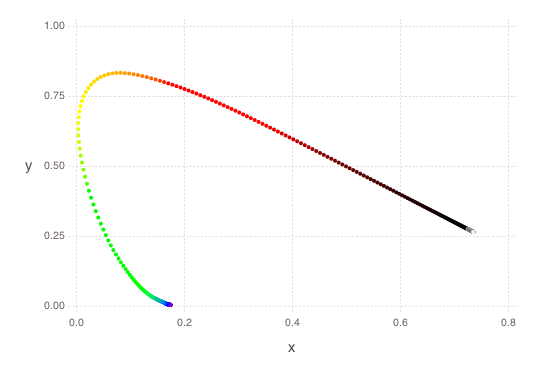

In [7]:
rainbowxyY = map(λ->convert(xyY, colormatch(λ)), 380:780)
plot(Geom.point, Theme(key_position=:none, default_point_size=2px, highlight_width=0px),
    x=[c.x for c in rainbowxyY], y=[c.y for c in rainbowxyY],
    color=[1:length(rainbowxyY);],
    Scale.color_discrete_manual(rainbow.C...))

It is easy to normalize the perceptual color in the xyY coordinate system.

In [8]:
#Convert XYZ to normalized xyY (with luminosity Y=1.0)
function normalize0(c::XYZ)
    d=convert(xyY, c)
    xyY(d.x, d.y, 1.0)
end

#Convolution with flat power spectrum
mapreduce(colormatch, +, 380:780) |> normalize0

Oops, this isn't white. What's going on?

Turns out that this is a white point issue. The definition I wanted turns out to be the E white point (`Color.WP_E`), whereas the CIE standard uses a different default white point (`Color.WP_DEFAULT`), which is the D65 white point  (`Color.WP_D65`, the 'noon daylight' standard used by most displays). Conveniently, `Color.jl` provides `Color.whitebalance` to correct for the difference in white points. So let's try this again.

In [9]:
#Convert XYZ to normalized xyY with white balancing
function normalize(c::XYZ; docorrect::Bool=true)
    d = convert(xyY, docorrect ?
    Colors.whitebalance(c, Colors.WP_E, Colors.WP_DEFAULT) : c)
    xyY(d.x, d.y, 1.0)
end

#Convolution with flat power spectrum
mapreduce(colormatch, +, 380:780) |> normalize

Ok, this looks white now. We're ready to start visualizing some physical data!

## Blackbody radiation

Perhaps the easiest physically relevant power spectrum to look at is that of blackbody radiation, which is described by Planck's law:

$$ B_\lambda (T) = \frac{2hc^2}{\lambda^5}
     \frac{1}{\left(\exp\left(\frac{hc}{kT}\right) - 1\right)}
$$

The function definition below makes use of the [SIUnits.jl](http://github.com/Keno/SIUnits.jl) package for defining unitful physical quantities.

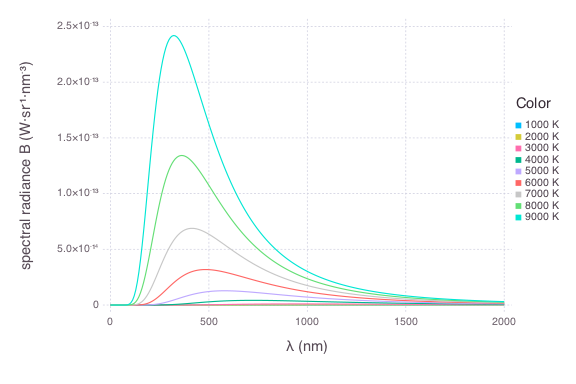

In [10]:
#Power spectrum for blackbody using Planck's law 
const hc_k  = 0.0143877696*K*m
const twohc²= 1.19104287e-16*Watt*m^2
planck{S1<:Real, S2<:Real}(λ::quantity(S1,Meter); T::quantity(S2,Kelvin)=5778.0K) =
λ≤0m ? zero(λ)*Watt*m^-4 : twohc²*λ^-5.0/(exp(hc_k/(λ*T))-1)

Trange = 1000K:1000K:9000K
Gadfly.set_default_plot_size(6inch, 4inch)
plot([λ->planck(λ*nm,T=T)*(1e-9m)^3/W for T in Trange], 0, 2000,
  Guide.xlabel("λ (nm)"),
  Guide.ylabel("spectral radiance B (W·sr⁻¹·nm⁻³)"),
  color=[string(T) for T in Trange],
)

Let's look at the computed colors for blackbodies at various temperatures. The code below defines a new conversion function from temperature to an xyY color. (Note: For some reason, I got better results by disabling color correction in `normalize`. I'm not sure why.)

In [11]:
import Base.convert
convert{S<:Real}(::Type{xyY}, T::quantity(S, K)) = 
  mapreduce(λ->planck(λ*nm,T=T)*m^3/Watt*colormatch(λ), +, 380:780) |>
  normalize0

blackbodies = xyY[convert(xyY, T) for T in 30K:30K:10000K]
ColorVector(blackbodies)

In [12]:
T☉=5778K #Temperature of the sun
@show convert(xyY, T☉) 

convert(xyY,T☉) = xyY{Float64}(0.3264516665261927,0.33577118189776,1.0)

To check the computed color, we can compare our computed color against what is called the [Planckian locus](http://en.wikipedia.org/wiki/Planckian_locus), which is the trajectory in the chromaticity space $(x, y)$. There are known approximations using cubic splines as a function of the reciprocal temperature $1/T$.

`Colors.jl` also provides a `colordiff` function which quantifies the distance between two colors using the CIEDE2000 color-difference formula [(pdf)](http://www.ece.rochester.edu/~gsharma/ciede2000/ciede2000noteCRNA.pdf). (I'm not sure what the units are though.)

In [13]:
#Use cubic spline formula from Wikipedia
function planckian_locus{S<:Real}(T::quantity(S, K))
    T=T/K#Strip out the unit
    x = 1667<=T<=4000 ? -0.2661239e9/T^3-0.2343580e6/T^2+0.8776956e3/T+0.179910 :
        4000<=T<=25000? -3.0258469e9/T^3+2.1070379e6/T^2+0.2226347e3/T+0.230390 :
        error("Temperature T=$T exceeds allowed limits of 1667<=T<=25000")
    y = 1667<=T<=2222 ? -1.1063814x^3-1.34811020x^2+2.18555832x-0.20219683 :
        2222<=T<=4000 ? -0.9549476x^3-1.37418593x^2+2.09137015x-0.16748867 :
        4000<=T<=25000?  3.0817580x^3-5.87338670x^2+3.75112997x-0.37001483 :
        error("Temperature T=$T exceeds allowed limits of 1667<=T<=25000")
    xyY(x, y, 1.0)
end

sun_approx = planckian_locus(T☉)
sun        = convert(xyY, T☉)

display([sun_approx, sun])
println(sun_approx)
println(sun)
println(colordiff(sun_approx, sun))


xyY{Float64}(0.3163481445268952,0.32642733641049293,1.0)
xyY{Float64}(0.3264516665261927,0.33577118189776,1.0)
4.

As a final check, overlay the approximate Planckian locus with the computed one from the blackbody spectrum. Close enough, maybe?

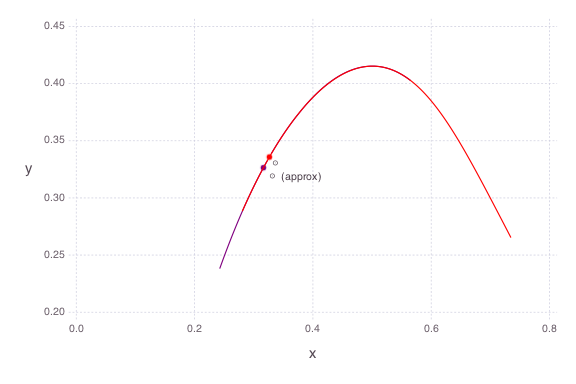

950749255014589


In [14]:
locus = map(T->planckian_locus(T*K), 1667:30:25000)

plot(Guide.xlabel("x"), Guide.ylabel("y"),
  layer(Geom.line, x=[c.x for c in blackbodies], y=[c.y for c in blackbodies], Theme(default_color=colorant"red")), 
  layer(Geom.point, x=repmat([sun.x], 2), y=repmat([sun.y], 2), Theme(default_color=colorant"red")),
  layer(Geom.label, x=[sun.x], y=[sun.y], label=["☉"]),

  layer(Geom.line, x=[c.x for c in locus], y=[c.y for c in locus], Theme(default_color=colorant"purple")),
  layer(Geom.point, x=repmat([sun_approx.x], 2), y=repmat([sun_approx.y], 2), Theme(default_color=colorant"purple")),
  layer(Geom.label, x=[sun_approx.x], y=[sun_approx.y], label=["☉ (approx)"]),
)

## The chemistry of color

With all this machinery in place to process power spectra, we can start to work with some really interesting data from the field of photochemistry. Chemists have measured the spectra of light [absorbed](http://en.wikipedia.org/wiki/Absorption_spectroscopy) and [emitted](http://en.wikipedia.org/wiki/Emission_spectrum) from a large variety of molecules. From this data, it is possible to compute the perceived color of a given molecule.

The spectral data come in several formats which require further processing. The light absorption properties of molecules can be reported in terms of [absorbance](http://en.wikipedia.org/wiki/Absorbance), optical density, [optical cross section](http://en.wikipedia.org/wiki/Optical_cross_section), [molar extinction coefficient](http://en.wikipedia.org/wiki/Molar_absorptivity), complex [refractive index](http://en.wikipedia.org/wiki/Complex_index_of_refraction#Complex_index_of_refraction_and_absorption), etc., which are essentially the logarithm of a normalized [transmittance](http://en.wikipedia.org/wiki/Transmittance), the ratio of light intensities going through a sample vs. the intensity going in.

In [15]:
abstract Spectrum{T<:Real}

immutable AbsorbanceSpectrum{T<:Real} <: Spectrum{T}
    λ :: Vector{T}
    ϵ :: Vector{T} #Extinction coefficent, absorption cross-section or the like
end
AbsorbanceSpectrum(λ::Vector, ϵ::Vector) = AbsorbanceSpectrum(map(Float64, λ), map(Float64, ϵ))

immutable TransmissionSpectrum{T<:Real} <: Spectrum{T}
    λ :: Vector{T}
    T :: Vector{T} #Transmission coefficent
end

import Base.show
function show(S::AbsorbanceSpectrum)
    plot(Geom.line, Guide.xlabel("λ (nm)"), Guide.ylabel("Absorbance"),
      x=S.λ, y=S.ϵ)
end

function show(S::TransmissionSpectrum)
    plot(Geom.line, Guide.xlabel("λ (nm)"), Guide.ylabel("Transmittance"),
      x=S.λ, y=S.T)
end

function show(Ss::Vector{TransmissionSpectrum})
    plot(Guide.xlabel("λ (nm)"), Guide.ylabel("Transmittance"),
    [layer(Geom.line, x=S.λ, y=S.T) for S in Ss]...)
end

show (generic function with 194 methods)

We can reconstruct the transmittance spectrum from the corresponding absorbance spectrum using the [Beer-Lambert law](http://en.wikipedia.org/wiki/Beer-Lambert_law):

$$T = {10}^{-c l \epsilon} = e^{-\sigma l N}$$

where $T$ is the transmittance, $\epsilon$ is the (decadic) molar extinction coefficent, $c$ is the molar concentration of the sample, $l$ is the optical path length, the distance light travels in the sample, $\sigma$ is the optical cross-section, and $N$ is the number concentration of the sample.

In [16]:
convert(::Type{TransmissionSpectrum}, S::AbsorbanceSpectrum; cl::Real=0.0001) =
TransmissionSpectrum(S.λ, exp10(-S.ϵ*cl)) #Beer-Lambert Law

convert (generic function with 769 methods)

The transmission spectrum is a function of light intensity over wavelength, and can therefore be projected directly into the XYZ color space as described in the previous section. (In the code snippet below, I've also included some heuristics to cover possible missing data in the transmission spectrum.)

In [17]:
function convert(::Type{xyY}, S::TransmissionSpectrum)
    #Calculate convolution of spectrum with XYZ color transfer functions
    color = reduce(+, [0.0; map(abs, diff(S.λ))].*S.T.*map(colormatch, S.λ))
    #Add in any missing parts of the spectrum (extrapolate spectrum from its endpoints)
    if (lolim=floor(minimum(S.λ))) > 380
        color += S.T[1]*reduce(+, map(colormatch, 380:lolim))
    end
    if (hilim=ceil(maximum(S.λ))) < 780
        color += S.T[end]*reduce(+, map(colormatch, hilim:780))
    end
    convert(xyY, color)
end

convert(::Type{xyY}, S::AbsorbanceSpectrum) = convert(xyY, convert(TransmissionSpectrum, S))

convert (generic function with 771 methods)

However, this reconstruction requires information about the concentration and thickness of the sample, which is normalized out in most reported data. What we can do here is to explore how the perceived color depends on the concentration. Here I've chosen to vary the concentration factor $cl=\sigma N$ by sweeping over the maximal transmittance $T_{max}$ in the visible spectrum:

$$cl = - \frac{log_{10}(T_{max})}{\epsilon}$$

and the computed color can be plotted in the $xy$ chromaticity plane as a function of the concentration factor.

In [18]:
#Compute a series of transmission spectra scaled to a desired maximum transmission
function calc_transmission(A::AbsorbanceSpectrum; maxTs=1.0:-0.0025:0.0)
    colors = xyY[]
    spectra = TransmissionSpectrum[]
    for maxT in maxTs
        scalefactor = -log10(maxT)/minimum(A.ϵ[A.ϵ.>0])
        T = convert(TransmissionSpectrum, A, cl=scalefactor)
        C = convert(xyY, T)
        push!(spectra, T)
        push!(colors, convert(xyY, C))
    end
    colors, spectra
end

#Plot trajectory in chromaticity plane
function plot_xy(C::AbstractVector{xyY})
    #Filter out non-finite color values
    xs = Float64[]
    ys = Float64[]
    cols = Int[]
    Cs = Colorant[]
    for i in eachindex(C)
        if isfinite(C[i].x) && isfinite(C[i].y)
            push!(xs, C[i].x)
            push!(ys, C[i].y)
            push!(cols, i)
            push!(Cs, C[i])
        end
    end

    plot(x=xs, y=ys, color=cols,
    Scale.color_discrete_manual(Cs...),
    Geom.point, Theme(key_position=:none, default_point_size=3px, highlight_width=0px))
end

plot_xy (generic function with 1 method)

Finally, here are some short routines for parsing spectral data.

In [19]:
function parse_jcampdx(filename)
    #This supports only the uncompressed JCAMP-DX file format
    #which is essentially CSV with a header
    rawspectrum=readcsv(filename, skipstart=20)
    #The columns are wavelength (nm) and log10 of molar extinction coefficient (M-1 cm-1)
    AbsorbanceSpectrum(rawspectrum[:,1], exp10(rawspectrum[:,2]))
end

function parse_photochemcad(filename)
    rawspectrum=readdlm(filename, '\t')
    rawspectrum=reshape(rawspectrum, (length(rawspectrum)÷2,2))

    #The columns are wavelength (nm) and molar extinction coefficient (M-1 cm-1)
    AbsorbanceSpectrum(rawspectrum[:,1],
      max(rawspectrum[:,2], 0.0)) #truncate negative extinctions
end

parse_photochemcad (generic function with 1 method)

We are finally ready to start computing colors of molecules! The examples given below reflect (so to speak) a broad spectrum (ha) of molecular species, whose data are available online in several different formats.

I've also included some images of the compounds in question to compare the computed color swatches with pictures of the actual solutions or samples. Again, the color swatches show the entire gamut of colors possible from the given spectra, so each a picture should match a color in the range. (There's also a question about the white balance in each reference picture, which is somewhat of a wildcard.)

### Titanium (III) aqua ion

In [20]:
filename = "ti3aq.jdx" 
isfile(filename) || download("http://wwwchem.uwimona.edu.jm/spectra/ti3aq.jdx", filename)
rawspectrum=readdlm(filename, skipstart=30)
#The columns are wavelength (nm) and absorbance (arbitrary units)
A=AbsorbanceSpectrum(rawspectrum[:,1], rawspectrum[:,2])

function showcolors(A::AbsorbanceSpectrum)
    colors, Ts=calc_transmission(A)
    display(show(A))
    display(show(Ts[1:20:end]))
    display(plot_xy(colors))
    display(ColorVector(colors))
end
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 -500 
 0 
 500 
 1000 
 1500 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M35.59,60.8 L 36.81 61.71 38.03 62.54 39.25 63.26 40.47 63.81 41.69 64.3 42.91 64.41 44.13 64.45 45.35 64.31 46.57 63.93 47.79 63.37 49.01 62.61 50.23 61.65 51.45 60.54 52.67 59.27 53.89 57.88 55.11 56.36 56.33 54.75 57.55 52.99 58.77 51.12 59.99 49.13 61.21 46.97 62.43 44.66 63.65 42.23 64.87 39.67 66.09 37.08 67.31 34.47 68.53 31.96 69.75 29.57 70.97 27.45 72.19 25.67 73.41 24.32 74.63 23.41 75.85 22.96 77.07 22.95 78.29 23.34 79.51 24.04 80.73 24.99 81.95 26.12 83.17 27.34 84.39 28.58 85.61 29.79 86.83 30.96 88.05 32.03 89.27 33.01 90.49 33.9 91.71 34.77 92.93 35.61 94.15 36.42 95.37 37.28 96.59 38.2 97.81 39.17 99.03 40.27 100.25 41.49 101.47 42.81 102.69 44.23 103.91 45.75 105.13 47.32 106.35 48.96 107.57 50.62 108.8 52.31 110.02 54 111.24 55.66 112.46 57.29 113.68 58.87 114.9 60.41 116.12 61.84 117.34 63.23 118.56 64.5 119.78 65.67 121 66.78 122.22 67.75 123.44 68.64 124.66 69.35 125.88 69.98 127.1 70.54 128.32 70.9 129.54 71.12 130.76 71.52 131.98 72 133.2 72.49 134.42 72.89 135.64 73.34 136.86 73.7 138.08 74.08 139.3 74.39 140.52 74.7 141.74 74.99"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5×10⁶ 
 -4×10⁶ 
 -3×10⁶ 
 -2×10⁶ 
 -1×10⁶ 
 0 
 1×10⁶ 
 2×10⁶ 
 3×10⁶ 
 4×10⁶ 
 5×10⁶ 
 6×10⁶ 
 7×10⁶ 
 8×10⁶ 
 9×10⁶ 
 -4.0×10⁶ 
 -3.8×10⁶ 
 -3.6×10⁶ 
 -3.4×10⁶ 
 -3.2×10⁶ 
 -3.0×10⁶ 
 -2.8×10⁶ 
 -2.6×10⁶ 
 -2.4×10⁶ 
 -2.2×10⁶ 
 -2.0×10⁶ 
 -1.8×10⁶ 
 -1.6×10⁶ 
 -1.4×10⁶ 
 -1.2×10⁶ 
 -1.0×10⁶ 
 -8.0×10⁵ 
 -6.0×10⁵ 
 -4.0×10⁵ 
 -2.0×10⁵ 
 0 
 2.0×10⁵ 
 4.0×10⁵ 
 6.0×10⁵ 
 8.0×10⁵ 
 1.0×10⁶ 
 1.2×10⁶ 
 1.4×10⁶ 
 1.6×10⁶ 
 1.8×10⁶ 
 2.0×10⁶ 
 2.2×10⁶ 
 2.4×10⁶ 
 2.6×10⁶ 
 2.8×10⁶ 
 3.0×10⁶ 
 3.2×10⁶ 
 3.4×10⁶ 
 3.6×10⁶ 
 3.8×10⁶ 
 4.0×10⁶ 
 4.2×10⁶ 
 4.4×10⁶ 
 4.6×10⁶ 
 4.8×10⁶ 
 5.0×10⁶ 
 5.2×10⁶ 
 5.4×10⁶ 
 5.6×10⁶ 
 5.8×10⁶ 
 6.0×10⁶ 
 6.2×10⁶ 
 6.4×10⁶ 
 6.6×10⁶ 
 6.8×10⁶ 
 7.0×10⁶ 
 7.2×10⁶ 
 7.4×10⁶ 
 7.6×10⁶ 
 7.8×10⁶ 
 8.0×10⁶ 
 -5×10⁶ 
 0 
 5×10⁶ 
 1×10⁷ 
 -4.0×10⁶ 
 -3.5×10⁶ 
 -3.0×10⁶ 
 -2.5×10⁶ 
 -2.0×10⁶ 
 -1.5×10⁶ 
 -1.0×10⁶ 
 -5.0×10⁵ 
 0 
 5.0×10⁵ 
 1.0×10⁶ 
 1.5×10⁶ 
 2.0×10⁶ 
 2.5×10⁶ 
 3.0×10⁶ 
 3.5×10⁶ 
 4.0×10⁶ 
 4.5×10⁶ 
 5.0×10⁶ 
 5.5×10⁶ 
 6.0×10⁶ 
 6.5×10⁶ 
 7.0×10⁶ 
 7.5×10⁶ 
 8.0×10⁶ 
 
 
 Absorbance

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 -500 
 0 
 500 
 1000 
 1500 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M32.16,80.71 L 33.41 80.71 34.67 80.71 35.93 80.71 37.19 80.71 38.45 80.71 39.71 80.71 40.96 80.71 42.22 80.71 43.48 80.71 44.74 80.71 46 80.71 47.25 80.71 48.51 80.71 49.77 80.71 51.03 80.71 52.29 80.71 53.55 80.71 54.8 80.71 56.06 80.71 57.32 80.71 58.58 80.71 59.84 80.71 61.1 80.71 62.35 80.71 63.61 80.71 64.87 80.71 66.13 80.71 67.39 80.71 68.65 80.71 69.9 80.71 71.16 80.71 72.42 80.71 73.68 80.71 74.94 80.71 76.2 80.71 77.45 80.71 78.71 80.71 79.97 80.71 81.23 80.71 82.49 80.71 83.74 80.71 85 80.71 86.26 80.71 87.52 80.71 88.78 80.71 90.04 80.71 91.29 80.71 92.55 80.71 93.81 80.71 95.07 80.71 96.33 80.71 97.59 80.71 98.84 80.71 100.1 80.71 101.36 80.71 102.62 80.71 103.88 80.71 105.14 80.71 106.39 80.71 107.65 80.71 108.91 80.71 110.17 80.71 111.43 80.71 112.68 80.71 113.94 80.71 115.2 80.71 116.46 80.71 117.72 80.71 118.98 80.71 120.23 80.71 121.49 80.71 122.75 80.71 124.01 80.71 125.27 80.71 126.53 80.71 127.78 80.71 129.04 80.71 130.3 80.71 131.56 80.71 132.82 80.71 134.08 80.71 135.33 80.71 136.59 80.71 137.85 80.71 139.11 80.71 140.37 80.71 141.63 80.71"/>
 
 
 <path fill="none" d="M32.16,80.7 L 33.41 80.7 34.67 80.7 35.93 80.7 37.19 80.69 38.45 80.69 39.71 80.69 40.96 80.69 42.22 80.69 43.48 80.69 44.74 80.7 46 80.7 47.25 80.7 48.51 80.7 49.77 80.7 51.03 80.7 52.29 80.71 53.55 80.71 54.8 80.71 56.06 80.71 57.32 80.71 58.58 80.71 59.84 80.71 61.1 80.71 62.35 80.71 63.61 80.71 64.87 80.71 66.13 80.71 67.39 80.71 68.65 80.71 69.9 80.71 71.16 80.71 72.42 80.71 73.68 80.71 74.94 80.71 76.2 80.71 77.45 80.71 78.71 80.71 79.97 80.71 81.23 80.71 82.49 80.71 83.74 80.71 85 80.71 86.26 80.71 87.52 80.71 88.78 80.71 90.04 80.71 91.29 80.71 92.55 80.71 93.81 80.71 95.07 80.71 96.33 80.71 97.59 80.71 98.84 80.71 100.1 80.71 101.36 80.71 102.62 80.71 103.88 80.71 105.14 80.71 106.39 80.71 107.65 80.71 108.91 80.71 110.17 80.71 111.43 80.71 112.68 80.7 113.94 80.7 115.2 80.7 116.46 80.7 117.72 80.69 118.98 80.68 120.23 80.66 121.49 80.62 122.75 80.57 124.01 80.51 125.27 80.44 126.53 80.35 127.78 80.28 129.04 80.22 130.3 80.11 131.56 79.94 132.82 79.72 134.08 79.48 135.33 79.16 136.59 78.84 137.85 78.42 139.11 78.02 140.37 77.55 141.63 77.02"/>
 
 
 <path fill="none" d="M32.16,80.68 L 33.41 80.67 34.67 80.66 35.93 80.64 37.19 80.62 38.45 80.61 39.71 80.6 40.96 80.6 42.22 80.61 43.48 80.62 44.74 80.64 46 80.66 47.25 80.67 48.51 80.68 49.77 80.69 51.03 80.7 52.29 80.7 53.55 80.7 54.8 80.7 56.06 80.7 57.32 80.71 58.58 80.71 59.84 80.71 61.1 80.71 62.35 80.71 63.61 80.71 64.87 80.71 66.13 80.71 67.39 80.71 68.65 80.71 69.9 80.71 71.16 80.71 72.42 80.71 73.68 80.71 74.94 80.71 76

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 -1 
 0 
 1 
 2 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 -0.40 
 -0.38 
 -0.36 
 -0.34 
 -0.32 
 -0.30 
 -0.28 
 -0.26 
 -0.24 
 -0.22 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 -0.5 
 0.0 
 0.5 
 1.0 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 
 
 y

Here is a picture of titanium (III) chloride solution from Wikipedia.

![titanium(iii) chloride solution](http://upload.wikimedia.org/wikipedia/commons/c/cd/TiCl3.jpg)

### Copper (II) aqua ion

In [21]:
filename="cu2aq.jdx"
isfile(filename) || download("http://wwwchem.uwimona.edu.jm/spectra/cu2aq.jdx", filename)
rawspectrum=readdlm(filename, skipstart=30)
#The columns are wavelength (nm) and absorbance (arbitrary units)
A=AbsorbanceSpectrum(rawspectrum[:,1], rawspectrum[:,2])
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -1500 
 -1000 
 -500 
 0 
 500 
 1000 
 1500 
 2000 
 2500 
 -1000 
 -950 
 -900 
 -850 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 1650 
 1700 
 1750 
 1800 
 1850 
 1900 
 1950 
 2000 
 -1000 
 0 
 1000 
 2000 
 -1000 
 -900 
 -800 
 -700 
 -600 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 1600 
 1700 
 1800 
 1900 
 2000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M67.51,80.33 L 68.11 80.38 68.7 80.42 69.3 80.44 69.9 80.45 70.5 80.43 71.1 80.43 71.7 80.41 72.3 80.41 72.9 80.42 73.5 80.42 74.1 80.45 74.7 80.47 75.3 80.49 75.89 80.52 76.49 80.54 77.09 80.55 77.69 80.56 78.29 80.57 78.89 80.57 79.49 80.58 80.09 80.58 80.69 80.57 81.29 80.57 81.89 80.57 82.49 80.58 83.08 80.57 83.68 80.56 84.28 80.54 84.88 80.53 85.48 80.51 86.08 80.48 86.68 80.45 87.28 80.42 87.88 80.37 88.48 80.32 89.08 80.26 89.68 80.18 90.27 80.09 90.87 79.99 91.47 79.87 92.07 79.73 92.67 79.56 93.27 79.37 93.87 79.16 94.47 78.92 95.07 78.63 95.67 78.31 96.27 77.95 96.87 77.55 97.47 77.09 98.06 76.57 98.66 75.99 99.26 75.35 99.86 74.64 100.46 73.84 101.06 72.97 101.66 72.02 102.26 70.99 102.86 69.88 103.46 68.69 104.06 67.41 104.66 66.06 105.25 64.64 105.85 63.14 106.45 61.58 107.05 59.97 107.65 58.31 108.25 56.6 108.85 54.88 109.45 53.16 110.05 51.42 110.65 49.7 111.25 48 111.85 46.31 112.44 44.7 113.04 43.12 113.64 41.61 114.24 40.18 114.84 38.84 115.44 37.57 116.04 36.41 116.64 35.34 117.24 34.38 117.84 33.52 118.44 32.78 119.04 32.15 119.64 31.61 120.23 31.18 120.83 30.86 121.43 30.6 122.03 30.47 122.63 30.36 123.23 30.45 123.83 30.59 124.43 30.78 125.03 31.03 125.63 31.33 126.23 31.68 126.83 32.09 127.42 32.52 128.02 33.01 128.62 33.53 129.22 34.55 129.82 35.11 130.42 35.71 131.02 36.25 131.62 36.84 132.22 37.45 132.82 38.06 133.42 38.67 134.02 39.25 134.61 39.85 135.21 40.45 135.81 41.07 136.41 41.67 137.01 42.24 137.61 42.81 138.21 43.41 138.81 44.02 139.41 44.53 140.01 45.12 140.61 45.68 141.21 46.25 141.8 46.8 142.4 47.42 143 48 143.6 48.57"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.0×10⁷ 
 -1.5×10⁷ 
 -1.0×10⁷ 
 -5.0×10⁶ 
 0 
 5.0×10⁶ 
 1.0×10⁷ 
 1.5×10⁷ 
 2.0×10⁷ 
 2.5×10⁷ 
 3.0×10⁷ 
 3.5×10⁷ 
 -1.50×10⁷ 
 -1.45×10⁷ 
 -1.40×10⁷ 
 -1.35×10⁷ 
 -1.30×10⁷ 
 -1.25×10⁷ 
 -1.20×10⁷ 
 -1.15×10⁷ 
 -1.10×10⁷ 
 -1.05×10⁷ 
 -1.00×10⁷ 
 -9.50×10⁶ 
 -9.00×10⁶ 
 -8.50×10⁶ 
 -8.00×10⁶ 
 -7.50×10⁶ 
 -7.00×10⁶ 
 -6.50×10⁶ 
 -6.00×10⁶ 
 -5.50×10⁶ 
 -5.00×10⁶ 
 -4.50×10⁶ 
 -4.00×10⁶ 
 -3.50×10⁶ 
 -3.00×10⁶ 
 -2.50×10⁶ 
 -2.00×10⁶ 
 -1.50×10⁶ 
 -1.00×10⁶ 
 -5.00×10⁵ 
 0 
 5.00×10⁵ 
 1.00×10⁶ 
 1.50×10⁶ 
 2.00×10⁶ 
 2.50×10⁶ 
 3.00×10⁶ 
 3.50×10⁶ 
 4.00×10⁶ 
 4.50×10⁶ 
 5.00×10⁶ 
 5.50×10⁶ 
 6.00×10⁶ 
 6.50×10⁶ 
 7.00×10⁶ 
 7.50×10⁶ 
 8.00×10⁶ 
 8.50×10⁶ 
 9.00×10⁶ 
 9.50×10⁶ 
 1.00×10⁷ 
 1.05×10⁷ 
 1.10×10⁷ 
 1.15×10⁷ 
 1.20×10⁷ 
 1.25×10⁷ 
 1.30×10⁷ 
 1.35×10⁷ 
 1.40×10⁷ 
 1.45×10⁷ 
 1.50×10⁷ 
 1.55×10⁷ 
 1.60×10⁷ 
 1.65×10⁷ 
 1.70×10⁷ 
 1.75×10⁷ 
 1.80×10⁷ 
 1.85×10⁷ 
 1.90×10⁷ 
 1.95×10⁷ 
 2.00×10⁷ 
 2.05×10⁷ 
 2.10×10⁷ 
 2.15×10⁷ 
 2.20×10⁷ 
 2.25×10⁷ 
 2.30×10⁷ 
 2.35×10⁷ 
 2.40×10⁷ 
 2.45×10⁷ 
 2.50×10⁷ 
 2.55×10⁷ 
 2.6

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -1500 
 -1000 
 -500 
 0 
 500 
 1000 
 1500 
 2000 
 2500 
 -1000 
 -950 
 -900 
 -850 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 1650 
 1700 
 1750 
 1800 
 1850 
 1900 
 1950 
 2000 
 -1000 
 0 
 1000 
 2000 
 -1000 
 -900 
 -800 
 -700 
 -600 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 1600 
 1700 
 1800 
 1900 
 2000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M63.61,80.71 L 64.24 80.71 64.87 80.71 65.5 80.71 66.13 80.71 66.76 80.71 67.39 80.71 68.02 80.71 68.65 80.71 69.27 80.71 69.9 80.71 70.53 80.71 71.16 80.71 71.79 80.71 72.42 80.71 73.05 80.71 73.68 80.71 74.31 80.71 74.94 80.71 75.57 80.71 76.2 80.71 76.82 80.71 77.45 80.71 78.08 80.71 78.71 80.71 79.34 80.71 79.97 80.71 80.6 80.71 81.23 80.71 81.86 80.71 82.49 80.71 83.12 80.71 83.74 80.71 84.37 80.71 85 80.71 85.63 80.71 86.26 80.71 86.89 80.71 87.52 80.71 88.15 80.71 88.78 80.71 89.41 80.71 90.04 80.71 90.67 80.71 91.29 80.71 91.92 80.71 92.55 80.71 93.18 80.71 93.81 80.71 94.44 80.71 95.07 80.71 95.7 80.71 96.33 80.71 96.96 80.71 97.59 80.71 98.21 80.71 98.84 80.71 99.47 80.71 100.1 80.71 100.73 80.71 101.36 80.71 101.99 80.71 102.62 80.71 103.25 80.71 103.88 80.71 104.51 80.71 105.14 80.71 105.76 80.71 106.39 80.71 107.02 80.71 107.65 80.71 108.28 80.71 108.91 80.71 109.54 80.71 110.17 80.71 110.8 80.71 111.43 80.71 112.06 80.71 112.68 80.71 113.31 80.71 113.94 80.71 114.57 80.71 115.2 80.71 115.83 80.71 116.46 80.71 117.09 80.71 117.72 80.71 118.35 80.71 118.98 80.71 119.61 80.71 120.23 80.71 120.86 80.71 121.49 80.71 122.12 80.71 122.75 80.71 123.38 80.71 124.01 80.71 124.64 80.71 125.27 80.71 125.9 80.71 126.53 80.71 127.16 80.71 127.78 80.71 128.41 80.71 129.04 80.71 129.67 80.71 130.3 80.71 130.93 80.71 131.56 80.71 132.19 80.71 132.82 80.71 133.45 80.71 134.08 80.71 134.7 80.71 135.33 80.71 135.96 80.71 136.59 80.71 137.22 80.71 137.85 80.71 138.48 80.71 139.11 80.71 139.74 80.71 140.37 80.71 141 80.71 141.63 80.71 142.25 80.71 142.88 80.71 143.51 80.71"/>
 
 
 <path fill="none" d="M63.61,80.69 L 64.24 80.67 64.87 80.62 65.5 80.56 66.13 80.54 66.76 80.58 67.39 80.6 68.02 80.63 68.65 80.63 69.27 80.62 69.9 80.6 70.53 80.51 71.16 80.44 71.79 80.22 72.42 79.76 73.05 79.23 73.68 78.57 74.31 78.12 74.94 77.28 75.57 77.47 76.2 77.16 76.82 77.18 77.45 77.8 78.08 77.39 78.71 77.41 79.34 77.02 79.97 77.58 80.6 78.44 81.23 79.05 81.86 79.52 82.49 79.95 83.12 80.33 83.74 80.5 84.37 80.62 85 80.67 85.63 80.7 86.26 80.7 86.89 80.71 87.52 80.71 88.15 80.71 88.78 80.71 89.41 80.71 90.04 80.71 90.67 80.71 91.29 80.71 91.92 80.71 92.55 80.71 93.18 80.71 93.81 80.71 94.44 80.71 95.07 80.71 95.7 80.71 96.33 80.71 96.96 80.71 97.59 80.71 98.21 80.71 98.84 80.71 99.47 80.71 100.1 80.71 100.73 80.71 101.36 80.71 101.99 80.71 102.62 80.71 103.25 80.71 103.88 80.71 104.51 80.71 105.14 80.71 105.76 80.71 106.39 80.71 107.02 80.71 107.65 80.71 108.28 80.71 108.91 80.71 109.54 80.71 110.17 80.71 110.8 80.71 111.43 80.71 112.06 80.71 112.68 80.71 113.31 80.71 113.94 80.71 114.57 80.71 115.2 80.71 115.83 80.71 116.46 80.71 117.09 80.71 117.72 80.71 118.35 80.71 118.98 80.71 119.61 80.71 120.23 80.71 120.86 80.71 121.49 80.71 122.12 80.71 122.75 8

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 -0.15 
 -0.14 
 -0.13 
 -0.12 
 -0.11 
 -0.10 
 -0.09 
 -0.08 
 -0.07 
 -0.06 
 -0.05 
 -0.04 
 -0.03 
 -0.02 
 -0.01 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 0.61 
 -0.25 
 0.00 
 0.25 
 0.50 
 0.75 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 -0.40 
 -0.38 
 -0.36 
 -0.34 
 -0.32 
 -0.30 
 -0.28 
 -0.26 
 -0.24 
 -0.22 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 -0.5 
 0.0 
 0.5 
 1.0 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 
 
 y

I found a particularly nice picture showing the diffusion of copper sulfate through an aqueous solution, showing a color gradient which corresponds very neatly with the gradient shown in the gamut!

![Copper sulfate diffusion in solution](http://www.nuffieldfoundation.org/sites/default/files/images/Diffusion%20of%20copper%20sulfate%20solution%20in%20water2_2262.jpg)

### Copper(II) chlorophyllin

This chlorophyll derivative is used as an edible dye (food additive E141) to give food the color of fresh leaves. So one would expect this to be a nice shade of green.

In [22]:
filename="e141.jdx"
isfile(filename) || download("http://wwwchem.uwimona.edu.jm/spectra/e141.jdx", filename)
rawspectrum=readdlm(filename, skipstart=30)
#The columns are wavelength (nm) and molar extinction coefficient (M-1 cm-1)
A=AbsorbanceSpectrum(rawspectrum[:,1], rawspectrum[:,2])
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 1600 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 1320 
 1340 
 1360 
 1380 
 1400 
 1420 
 1440 
 1460 
 1480 
 1500 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M32.37,40.64 L 34.76 38.35 37.16 35.09 39.56 31.08 41.95 29.83 44.35 26.85 46.75 28.5 49.14 31.2 51.54 44.65 53.93 55.34 56.33 61.35 58.73 65.43 61.12 68.49 63.52 69.96 65.92 70.41 68.31 71.4 70.71 71.5 73.11 71.12 75.5 71.53 77.9 70.84 80.3 68.62 82.69 68.09 85.09 68.34 87.49 65.52 89.88 59.95 92.28 61.33 94.67 67.52 97.07 72.34 99.47 73.72 101.86 75.25 104.26 76.56 106.66 77.61 109.05 78.33 111.45 78.83 113.85 79.2 116.24 79.44 118.64 79.72 121.04 79.65 123.43 80.1 125.83 79.8 128.23 80.16"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.0×10⁹ 
 -1.5×10⁹ 
 -1.0×10⁹ 
 -5.0×10⁸ 
 0 
 5.0×10⁸ 
 1.0×10⁹ 
 1.5×10⁹ 
 2.0×10⁹ 
 2.5×10⁹ 
 3.0×10⁹ 
 3.5×10⁹ 
 -1.50×10⁹ 
 -1.45×10⁹ 
 -1.40×10⁹ 
 -1.35×10⁹ 
 -1.30×10⁹ 
 -1.25×10⁹ 
 -1.20×10⁹ 
 -1.15×10⁹ 
 -1.10×10⁹ 
 -1.05×10⁹ 
 -1.00×10⁹ 
 -9.50×10⁸ 
 -9.00×10⁸ 
 -8.50×10⁸ 
 -8.00×10⁸ 
 -7.50×10⁸ 
 -7.00×10⁸ 
 -6.50×10⁸ 
 -6.00×10⁸ 
 -5.50×10⁸ 
 -5.00×10⁸ 
 -4.50×10⁸ 
 -4.00×10⁸ 
 -3.50×10⁸ 
 -3.00×10⁸ 
 -2.50×10⁸ 
 -2.00×10⁸ 
 -1.50×10⁸ 
 -1.00×10⁸ 
 -5.00×10⁷ 
 0 
 5.00×10⁷ 
 1.00×10⁸ 
 1.50×10⁸ 
 2.00×10⁸ 
 2.50×10⁸ 
 3.00×10⁸ 
 3.50×10⁸ 
 4.00×10⁸ 
 4.50×10⁸ 
 5.00×10⁸ 
 5.50×10⁸ 
 6.00×10⁸ 
 6.50×10⁸ 
 7.00×10⁸ 
 7.50×10⁸ 
 8.00×10⁸ 
 8.50×10⁸ 
 9.00×10⁸ 
 9.50×10⁸ 
 1.00×10⁹ 
 1.05×10⁹ 
 1.10×10⁹ 
 1.15×10⁹ 
 1.20×10⁹ 
 1.25×10⁹ 
 1.30×10⁹ 
 1.35×10⁹ 
 1.40×10⁹ 
 1.45×10⁹ 
 1.50×10⁹ 
 1.55×10⁹ 
 1.60×10⁹ 
 1.65×10⁹ 
 1.70×10⁹ 
 1.75×10⁹ 
 1.80×10⁹ 
 1.85×10⁹ 
 1.90×10⁹ 
 1.95×10⁹ 
 2.00×10⁹ 
 2.05×10⁹ 
 2.10×10⁹ 
 2.15×10⁹ 
 2.20×10⁹ 
 2.25×10⁹ 
 2.30×10⁹ 
 2.35×10⁹ 
 2.40×10⁹ 
 2.45×10⁹ 
 2.50×10⁹ 
 2.55×10⁹ 
 2.60×10⁹ 
 2.65×10⁹ 
 2.70×10⁹ 
 2.75×10⁹ 
 2.80×10⁹ 
 2.85×10⁹ 
 2.90×10⁹ 
 2.95×10⁹ 
 3.00×10⁹ 
 -2×10⁹ 
 0 
 2×10⁹ 
 4×10⁹ 
 -1.5×10⁹ 
 -1.4×10⁹ 
 -1.3×10⁹ 
 -1.2×10⁹ 
 -1.1×10⁹ 
 -1.0×10⁹ 
 -9.0×10⁸ 
 -8.0×10⁸ 
 -7.0×10⁸ 
 -6.0×10⁸ 
 -5.0×10⁸ 
 -4.0×10⁸ 
 -3.0×10⁸ 
 -2.0×10⁸ 
 -1.0×10⁸ 
 0 
 1.0×10⁸ 
 2.0×10⁸ 
 3.0×10⁸ 
 4.0×10⁸ 
 5.0×10⁸ 
 6.0×10⁸ 
 7.0×10⁸ 
 8.0×10⁸ 
 9.0×10⁸ 
 1.0×10⁹ 
 1.1×10⁹ 
 1.2×10⁹ 
 1.3×10⁹ 
 1.4×10⁹ 
 1.5×10⁹ 
 1.6×10⁹ 
 1.7×10⁹ 
 1.8×10⁹ 
 1.9×10⁹ 
 2.0×10⁹ 
 2.1×10⁹ 
 2.2×10⁹ 
 2.3×10⁹ 
 2.4×10⁹ 
 2.5×10⁹ 
 2.6×10⁹ 
 2.7×10⁹ 
 2.8×10⁹ 
 2.9×10⁹ 
 3.0×10⁹ 
 
 
 Absorbance

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 1600 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 1320 
 1340 
 1360 
 1380 
 1400 
 1420 
 1440 
 1460 
 1480 
 1500 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M26.7,80.71 L 29.22 80.71 31.74 80.71 34.25 80.71 36.77 80.71 39.29 80.71 41.8 80.71 44.32 80.71 46.84 80.71 49.35 80.71 51.87 80.71 54.39 80.71 56.9 80.71 59.42 80.71 61.93 80.71 64.45 80.71 66.97 80.71 69.48 80.71 72 80.71 74.52 80.71 77.03 80.71 79.55 80.71 82.07 80.71 84.58 80.71 87.1 80.71 89.62 80.71 92.13 80.71 94.65 80.71 97.17 80.71 99.68 80.71 102.2 80.71 104.72 80.71 107.23 80.71 109.75 80.71 112.27 80.71 114.78 80.71 117.3 80.71 119.82 80.71 122.33 80.71 124.85 80.71 127.36 80.71"/>
 
 
 <path fill="none" d="M26.7,80.71 L 29.22 80.71 31.74 80.71 34.25 80.71 36.77 80.71 39.29 80.71 41.8 80.71 44.32 80.71 46.84 80.71 49.35 80.71 51.87 80.71 54.39 80.71 56.9 80.71 59.42 80.71 61.93 80.71 64.45 80.71 66.97 80.71 69.48 80.71 72 80.71 74.52 80.71 77.03 80.71 79.55 80.71 82.07 80.71 84.58 80.71 87.1 80.71 89.62 80.71 92.13 80.71 94.65 80.71 97.17 80.71 99.68 80.71 102.2 80.71 104.72 80.71 107.23 80.71 109.75 80.7 112.27 80.69 114.78 80.63 117.3 80.38 119.82 80.47 122.33 78.01 124.85 80.19 127.36 77.02"/>
 
 
 <path fill="none" d="M26.7,80.71 L 29.22 80.71 31.74 80.71 34.25 80.71 36.77 80.71 39.29 80.71 41.8 80.71 44.32 80.71 46.84 80.71 49.35 80.71 51.87 80.71 54.39 80.71 56.9 80.71 59.42 80.71 61.93 80.71 64.45 80.71 66.97 80.71 69.48 80.71 72 80.71 74.52 80.71 77.03 80.71 79.55 80.71 82.07 80.71 84.58 80.71 87.1 80.71 89.62 80.71 92.13 80.71 94.65 80.71 97.17 80.71 99.68 80.71 102.2 80.71 104.72 80.71 107.23 80.7 109.75 80.68 112.27 80.58 114.78 80.34 117.3 79.56 119.82 79.83 122.33 74.92 124.85 79.07 127.36 73.33"/>
 
 
 <path fill="none" d="M26.7,80.71 L 29.22 80.71 31.74 80.71 34.25 80.71 36.77 80.71 39.29 80.71 41.8 80.71 44.32 80.71 46.84 80.71 49.35 80.71 51.87 80.71 54.39 80.71 56.9 80.71 59.42 80.71 61.93 80.71 64.45 80.71 66.97 80.71 69.48 80.71 72 80.71 74.52 80.71 77.03 80.71 79.55 80.71 82.07 80.71 84.58 80.71 87.1 80.71 89.62 80.71 92.13 80.71 94.65 80.71 97.17 80.71 99.68 80.71 102.2 80.71 104.72 80.7 107.23 80.69 109.75 80.59 112.27 80.31 114.78 79.78 117.3 78.32 119.82 78.79 122.33 71.64 124.85 77.51 127.36 69.65"/>
 
 
 <path fill="none" d="M26.7,80.71 L 29.22 80.71 31.74 80.71 34.25 80.71 36.77 80.71 39.29 80.71 41.8 80.71 44.32 80.71 46.84 80.71 49.35 80.71 51.87 80.71 54.39 80.71 56.9 80.71 59.42 80.71 61.93 80.71 64.45 80.71 66.97 80.71 69.48 80.71 72 80.71 74.52 80.71 77.03 80.71 79.55 80.71 82.07 80.71 84.58 80.71 87.1 80.71 89.

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 0.84 
 0.86 
 0.88 
 0.90 
 0.92 
 0.94 
 0.96 
 0.98 
 1.00 
 1.02 
 1.04 
 1.06 
 1.08 
 1.10 
 1.12 
 1.14 
 1.16 
 1.18 
 1.20 
 1.22 
 1.24 
 1.26 
 1.28 
 1.30 
 1.32 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 -0.22 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 0.84 
 0.86 
 0.88 
 0.90 
 0.92 
 0.94 
 0.96 
 0.98 
 1.00 
 1.02 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 
 
 y

![E141 food dye](http://i00.i.aliimg.com/photo/v0/270778768/vitamins_sodium_copper_chlorophyllin.jpg)

### Azobenzene

[Azobenzene](http://en.wikipedia.org/wiki/Azobenzene) is an azo compound which demonstrates a particular chemical reaction known as [photoisomerization](http://en.wikipedia.org/wiki/Photoisomerization).

In [23]:
#Download UV-vis spectrum from NIST Chemistry Webbook
jcampid = "C103333"    #azobenzene
filename = string(jcampid, ".jdx")
isfile(filename) || download("http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=$(jcampid)&Index=0&Type=UVVis", filename) 
A=parse_jcampdx(filename)
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 -100 
 -90 
 -80 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 140 
 150 
 160 
 170 
 180 
 190 
 200 
 210 
 220 
 230 
 240 
 250 
 260 
 270 
 280 
 290 
 300 
 310 
 320 
 330 
 340 
 350 
 360 
 370 
 380 
 390 
 400 
 410 
 420 
 430 
 440 
 450 
 460 
 470 
 480 
 490 
 500 
 510 
 520 
 530 
 540 
 550 
 560 
 570 
 580 
 590 
 600 
 610 
 620 
 630 
 640 
 650 
 660 
 670 
 680 
 690 
 700 
 710 
 720 
 730 
 740 
 750 
 760 
 770 
 780 
 790 
 800 
 -500 
 0 
 500 
 1000 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M37.29,40.48 L 37.29 40.48 37.39 40.44 37.49 40.4 37.6 40.36 37.6 40.36 37.76 40.41 37.93 40.46 38.1 40.51 39.45 41.26 39.48 41.52 39.5 41.79 39.52 42.05 39.52 42.05 39.59 42.2 39.66 42.35 39.71 42.51 39.71 42.51 39.74 42.76 40.55 44.37 40.6 45.01 40.64 45.63 40.68 46.23 40.96 49.66 40.98 49.06 41 48.44 41.02 47.81 41.43 52.44 41.43 52.44 41.46 51.84 41.49 51.22 41.51 50.57 41.56 52.56 41.69 52.67 41.74 54.51 41.77 53.95 41.8 53.37 41.82 52.79 41.82 52.79 42.13 56.5 42.18 56.24 42.23 55.98 42.28 55.71 42.46 57.88 42.46 57.88 42.46 57.79 42.47 57.7 42.47 57.61 42.47 57.61 42.51 57.59 42.52 58.1 42.55 57.57 42.58 58.32 42.59 57.55 42.63 58.54 42.63 58.54 42.69 59.32 42.74 60.07 42.79 60.79 42.97 61.37 43 61.89 43.04 62.14 43.09 62.36 43.52 63.36 43.52 63.36 43.54 63.67 43.55 63.34 43.55 63.98 43.55 64.29 43.58 63.33 43.62 63.31 43.93 64.67 43.95 64.78 43.98 65.27 43.98 65.27 43.98 64.89 44 65 44 65 44.01 65.21 44.01 65.37 44.03 65.47 44.03 65.03 44.04 65.15 44.05 65.58 44.06 65.06 44.09 65.09 44.09 65.09 44.56 66.77 44.58 66.56 44.6 66.33 44.62 66.11 45.46 67.57 45.53 67.67 45.59 67.77 45.64 67.88 46.37 68.47 46.41 68.47 46.44 68.47 46.47 68.47 46.47 68.47 46.63 68.53 46.79 68.59 46.94 68.65 47.49 69.24 47.76 69.26 48.02 69.27 48.27 69.28 48.27 69.28 48.28 69.18 48.29 69.13 48.29 69.09 48.3 69.04 48.38 69.32 48.48 69.35 48.57 69.38 48.57 69.38 48.63 69.44 48.69 69.49 48.74 69.55 48.74 69.55 48.77 69.6 48.8 69.66 48.82 69.71 48.85 69.38 49.02 69.4 49.19 69.41 49.35 69.42 49.35 69.42 49.45 69.48 49.54 69.54 49.63 69.59 49.82 69.6 49.98 69.59 50.15 69.58 50.32 69.56 50.32 69.56 50.35 69.51 50.39 69.46 50.44 69.4 51.46 69.15 51.56 68.83 51.63 68.65 51.73 68.47 52.17 67.88 52.17 67.88 52.24 67.91 52.25 67.69 52.31 67.94 52.34 67.48 52.37 67.96 52.44 67.28 53.18 66.69 53.19 66.56 53.2 66.42 53.21 66.28 53.21 66.28 53.24 66.21 53.28 66.14 53.32 66.07 53.96 65.56 53.97 65.36 53.99 65.15 54 64.93 54 64.93 54.07 64.9 54.14 64.87 54.22 64.84 54.22 64.84 54.23 64.75 54.23 64.66 54.24 64.56 54.24 64.56 54.38 64.5 54.52 64.44 54.66 64.38 54.66 64.38 54.74 64.03 54.83 63.67 54.92 63.31 55.74 62.81 55.79 62.48 55.84 62.14 55.9 61.79 55.9 61.79 56.04 61.67 56.18 61.54 56.32 61.42 56.32 61.42 56.4 61.25 56.48 61.08 56.57 60.91 56.57 60.91 56.57 60.83 56.58 60.75 56.58 60.67 56.58 60.67 56.61 60.6 56.65 60.52 56.69 60.44 56.69 60.44 56.75 60.38 56.82 60.33 56.89 60.26 57.16 59.18 57.2 58.91 57.25 58.63 57.3 58.35 57.3 58.35 57.33 58.29 57.37 

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 -100 
 -90 
 -80 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 140 
 150 
 160 
 170 
 180 
 190 
 200 
 210 
 220 
 230 
 240 
 250 
 260 
 270 
 280 
 290 
 300 
 310 
 320 
 330 
 340 
 350 
 360 
 370 
 380 
 390 
 400 
 410 
 420 
 430 
 440 
 450 
 460 
 470 
 480 
 490 
 500 
 510 
 520 
 530 
 540 
 550 
 560 
 570 
 580 
 590 
 600 
 610 
 620 
 630 
 640 
 650 
 660 
 670 
 680 
 690 
 700 
 710 
 720 
 730 
 740 
 750 
 760 
 770 
 780 
 790 
 800 
 -500 
 0 
 500 
 1000 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M31.84,80.71 L 31.84 80.71 31.95 80.71 32.05 80.71 32.17 80.71 32.17 80.71 32.33 80.71 32.51 80.71 32.68 80.71 34.1 80.71 34.14 80.71 34.16 80.71 34.18 80.71 34.18 80.71 34.25 80.71 34.32 80.71 34.39 80.71 34.39 80.71 34.42 80.71 35.26 80.71 35.32 80.71 35.36 80.71 35.4 80.71 35.69 80.71 35.71 80.71 35.74 80.71 35.76 80.71 36.19 80.71 36.19 80.71 36.22 80.71 36.25 80.71 36.27 80.71 36.33 80.71 36.46 80.71 36.52 80.71 36.54 80.71 36.57 80.71 36.6 80.71 36.6 80.71 36.92 80.71 36.97 80.71 37.03 80.71 37.08 80.71 37.27 80.71 37.27 80.71 37.27 80.71 37.28 80.71 37.28 80.71 37.28 80.71 37.32 80.71 37.33 80.71 37.36 80.71 37.4 80.71 37.41 80.71 37.45 80.71 37.45 80.71 37.51 80.71 37.56 80.71 37.62 80.71 37.8 80.71 37.84 80.71 37.88 80.71 37.94 80.71 38.39 80.71 38.39 80.71 38.4 80.71 38.41 80.71 38.41 80.71 38.42 80.71 38.45 80.71 38.49 80.71 38.81 80.71 38.84 80.71 38.86 80.71 38.86 80.71 38.87 80.71 38.88 80.71 38.88 80.71 38.89 80.71 38.89 80.71 38.92 80.71 38.92 80.71 38.93 80.71 38.94 80.71 38.95 80.71 38.98 80.71 38.98 80.71 39.47 80.71 39.49 80.71 39.51 80.71 39.53 80.71 40.42 80.71 40.49 80.71 40.56 80.71 40.61 80.71 41.38 80.71 41.42 80.71 41.45 80.71 41.48 80.71 41.48 80.71 41.65 80.71 41.82 80.71 41.98 80.71 42.56 80.71 42.84 80.71 43.11 80.71 43.38 80.71 43.38 80.71 43.39 80.71 43.39 80.71 43.4 80.71 43.4 80.71 43.49 80.71 43.59 80.71 43.69 80.71 43.69 80.71 43.75 80.71 43.81 80.71 43.87 80.71 43.87 80.71 43.9 80.71 43.93 80.71 43.95 80.71 43.99 80.71 44.16 80.71 44.34 80.71 44.5 80.71 44.5 80.71 44.61 80.71 44.71 80.71 44.8 80.71 45 80.71 45.17 80.71 45.35 80.71 45.53 80.71 45.53 80.71 45.56 80.71 45.6 80.71 45.65 80.71 46.72 80.71 46.83 80.71 46.9 80.71 47.01 80.71 47.47 80.71 47.47 80.71 47.55 80.71 47.56 80.71 47.62 80.71 47.65 80.71 47.68 80.71 47.75 80.71 48.52 80.71 48.54 80.71 48.55 80.71 48.56 80.71 48.56 80.71 48.59 80.71 48.63 80.71 48.68 80.71 49.34 80.71 49.36 80.71 49.38 80.71 49.4 80.71 49.4 80.71 49.46 80.71 49.54 80.71 49.62 80.71 49.62 80.71 49.63 80.71 49.64 80.71 49.64 80.71 49.64 80.71 49.79 80.71 49.94 80.71 50.08 80.71 50.08 80.71 50.17 80.71 50.26 80.71 50.36 80.71 51.22 80.71 51.27 80.71 51.33 80.71 51.39 80.71 51.39 80.71 51.54 80.71 51.68 80.71 51.83 80.71 51.83 80.71 51.91 80.71 52 80.71 52.09 80.71 52.09 80.71 52.09 80.71 52.1 80.71 52.1 80.71 52.1 80.71 52.13 80.71 52.17 80.71 52.22 80.71 52.22 80.71 52.28 80.71 52.35 80.71 52.43 80.71 52.71 80.71 52.75 80.71 52.81 80.71 52.86 80.71 52.86 80.71 52.8

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 0.0 
 0.2 
 0.4 
 0.6 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 0.61 
 0.62 
 0.63 
 0.64 
 0.65 
 0.66 
 0.67 
 0.68 
 0.69 
 0.70 
 0.71 
 0.72 
 0.73 
 0.74 
 0.75 
 0.76 
 0.77 
 0.78 
 0.79 
 0.80 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 
 
 y

Here is a picture of a thin film made from azobenzene.

![Azobenzene thin film](http://www.per-forms.net/wp-content/uploads/2010/11/Cliffffffboard-1.jpg)

### Dichromate [Cr$_2$O$_7$]$^{2-}$

In [24]:
filename="cr2o7.jdx"
isfile(filename) || download("http://wwwchem.uwimona.edu.jm/spectra/cr2o7.jdx", filename)
rawspectrum=readdlm(filename, skipstart=30)
#The columns are wavelength (nm) and absorbance (arbitrary units)
A=AbsorbanceSpectrum(rawspectrum[:,1], rawspectrum[:,2])
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -1000 
 -800 
 -600 
 -400 
 -200 
 0 
 200 
 400 
 600 
 800 
 1000 
 1200 
 1400 
 1600 
 1800 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 -1000 
 0 
 1000 
 2000 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M63.03,17.74 L 63.77 15.43 64.52 15.39 65.27 17.95 66.02 22.24 66.77 26.97 67.52 31.37 68.27 35.52 69.02 40.09 69.77 45.29 70.51 50.8 71.26 55.66 72.01 58.7 72.76 59.04 73.51 56.53 74.26 51.8 75.01 46.07 75.76 40.31 76.51 35.82 77.25 32.9 78 32.05 78.75 33.07 79.5 35.52 80.25 39.04 81 43.21 81.75 47.24 82.5 52.38 83.24 56.18 83.99 61.34 84.74 65.05 85.49 68.4 86.24 70.99 86.99 72.48 87.74 73.26 88.49 73.6 89.24 73.71 89.98 73.73 90.73 73.78 91.48 73.91 92.23 74.11 92.98 74.42 93.73 74.83 94.48 75.3 95.23 75.82 95.98 76.38 96.72 76.95 97.47 77.5 98.22 78.01 98.97 78.49 99.72 78.92 100.47 79.3 101.22 79.62 101.97 79.89 102.72 80.11 103.46 80.28 104.21 80.41 104.96 80.5 105.71 80.57 106.46 80.61 107.21 80.64 107.96 80.67 108.71 80.68 109.45 80.68 110.2 80.69 110.95 80.69 111.7 80.69 112.45 80.7 113.2 80.7 113.95 80.7 114.7 80.7 115.45 80.69 116.19 80.69 116.94 80.7 117.69 80.69 118.44 80.7 119.19 80.69 119.94 80.7 120.69 80.7 121.44 80.7 122.19 80.7 122.93 80.69 123.68 80.7 124.43 80.7 125.18 80.69 125.93 80.69 126.68 80.69 127.43 80.7 128.18 80.7 128.93 80.69 129.67 80.7 130.42 80.7 131.17 80.7 131.92 80.7 132.67 80.7 133.42 80.7 134.17 80.7 134.92 80.7 135.66 80.7 136.41 80.7 137.16 80.7 137.91 80.7 138.66 80.7"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.5×10⁷ 
 -2.0×10⁷ 
 -1.5×10⁷ 
 -1.0×10⁷ 
 -5.0×10⁶ 
 0 
 5.0×10⁶ 
 1.0×10⁷ 
 1.5×10⁷ 
 2.0×10⁷ 
 2.5×10⁷ 
 3.0×10⁷ 
 3.5×10⁷ 
 4.0×10⁷ 
 4.5×10⁷ 
 -2.0×10⁷ 
 -1.9×10⁷ 
 -1.8×10⁷ 
 -1.7×10⁷ 
 -1.6×10⁷ 
 -1.5×10⁷ 
 -1.4×10⁷ 
 -1.3×10⁷ 
 -1.2×10⁷ 
 -1.1×10⁷ 
 -1.0×10⁷ 
 -9.0×10⁶ 
 -8.0×10⁶ 
 -7.0×10⁶ 
 -6.0×10⁶ 
 -5.0×10⁶ 
 -4.0×10⁶ 
 -3.0×10⁶ 
 -2.0×10⁶ 
 -1.0×10⁶ 
 0 
 1.0×10⁶ 
 2.0×10⁶ 
 3.0×10⁶ 
 4.0×10⁶ 
 5.0×10⁶ 
 6.0×10⁶ 
 7.0×10⁶ 
 8.0×10⁶ 
 9.0×10⁶ 
 1.0×10⁷ 
 1.1×10⁷ 
 1.2×10⁷ 
 1.3×10⁷ 
 1.4×10⁷ 
 1.5×10⁷ 
 1.6×10⁷ 
 1.7×10⁷ 
 1.8×10⁷ 
 1.9×10⁷ 
 2.0×10⁷ 
 2.1×10⁷ 
 2.2×10⁷ 
 2.3×10⁷ 
 2.4×10⁷ 
 2.5×10⁷ 
 2.6×10⁷ 
 2.7×10⁷ 
 2.8×10⁷ 
 2.9×10⁷ 
 3.0×10⁷ 
 3.1×10⁷ 
 3.2×10⁷ 
 3.3×10⁷ 
 3.4×10⁷ 
 3.5×10⁷ 
 3.6×10⁷ 
 3.7×10⁷ 
 3.8×10⁷ 
 3.9×10⁷ 
 4.0×10⁷ 
 -2×10⁷ 
 0 
 2×10⁷ 
 4×10⁷ 
 -2.0×10⁷ 
 -1.8×10⁷ 
 -1.6×10⁷ 
 -1.4×10⁷ 
 -1.2×10⁷ 
 -1.0×10⁷ 
 -8.0×10⁶ 
 -6.0×10⁶ 
 -4.0×10⁶ 
 -2.0×10⁶ 
 0 
 2.0×10⁶ 
 4.0×10⁶ 
 6.0×10⁶ 
 8.0×10⁶ 
 1.0×10⁷ 
 1.2×10⁷ 
 1.4×10⁷ 
 1.6×10⁷ 
 1.8×10⁷ 
 2.0×10⁷ 
 2.2×10⁷ 
 2.4×10⁷ 
 2.6×10⁷ 
 2.8×10⁷ 
 3.0×10⁷ 
 3.2×10⁷ 
 3.4×10⁷ 
 3.6×10⁷ 
 3.8×10⁷ 
 4.0×10⁷ 
 
 
 Absorbance

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -1000 
 -800 
 -600 
 -400 
 -200 
 0 
 200 
 400 
 600 
 800 
 1000 
 1200 
 1400 
 1600 
 1800 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 -1000 
 0 
 1000 
 2000 
 -800 
 -750 
 -700 
 -650 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 1450 
 1500 
 1550 
 1600 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M58.89,80.71 L 59.68 80.71 60.47 80.71 61.25 80.71 62.04 80.71 62.83 80.71 63.61 80.71 64.4 80.71 65.19 80.71 65.97 80.71 66.76 80.71 67.54 80.71 68.33 80.71 69.12 80.71 69.9 80.71 70.69 80.71 71.48 80.71 72.26 80.71 73.05 80.71 73.84 80.71 74.62 80.71 75.41 80.71 76.2 80.71 76.98 80.71 77.77 80.71 78.55 80.71 79.34 80.71 80.13 80.71 80.91 80.71 81.7 80.71 82.49 80.71 83.27 80.71 84.06 80.71 84.85 80.71 85.63 80.71 86.42 80.71 87.2 80.71 87.99 80.71 88.78 80.71 89.56 80.71 90.35 80.71 91.14 80.71 91.92 80.71 92.71 80.71 93.5 80.71 94.28 80.71 95.07 80.71 95.86 80.71 96.64 80.71 97.43 80.71 98.21 80.71 99 80.71 99.79 80.71 100.57 80.71 101.36 80.71 102.15 80.71 102.93 80.71 103.72 80.71 104.51 80.71 105.29 80.71 106.08 80.71 106.87 80.71 107.65 80.71 108.44 80.71 109.22 80.71 110.01 80.71 110.8 80.71 111.58 80.71 112.37 80.71 113.16 80.71 113.94 80.71 114.73 80.71 115.52 80.71 116.3 80.71 117.09 80.71 117.88 80.71 118.66 80.71 119.45 80.71 120.23 80.71 121.02 80.71 121.81 80.71 122.59 80.71 123.38 80.71 124.17 80.71 124.95 80.71 125.74 80.71 126.53 80.71 127.31 80.71 128.1 80.71 128.89 80.71 129.67 80.71 130.46 80.71 131.24 80.71 132.03 80.71 132.82 80.71 133.6 80.71 134.39 80.71 135.18 80.71 135.96 80.71 136.75 80.71 137.54 80.71 138.32 80.71"/>
 
 
 <path fill="none" d="M58.89,80.71 L 59.68 80.71 60.47 80.71 61.25 80.71 62.04 80.71 62.83 80.71 63.61 80.71 64.4 80.71 65.19 80.71 65.97 80.71 66.76 80.71 67.54 80.71 68.33 80.71 69.12 80.71 69.9 80.71 70.69 80.71 71.48 80.71 72.26 80.71 73.05 80.71 73.84 80.71 74.62 80.71 75.41 80.71 76.2 80.71 76.98 80.71 77.77 80.71 78.55 80.71 79.34 80.71 80.13 80.71 80.91 80.71 81.7 80.71 82.49 80.71 83.27 80.71 84.06 80.71 84.85 80.71 85.63 80.71 86.42 80.71 87.2 80.71 87.99 80.71 88.78 80.71 89.56 80.71 90.35 80.71 91.14 80.71 91.92 80.71 92.71 80.71 93.5 80.71 94.28 80.71 95.07 80.71 95.86 80.71 96.64 80.71 97.43 80.71 98.21 80.71 99 80.71 99.79 80.71 100.57 80.71 101.36 80.71 102.15 80.71 102.93 80.71 103.72 80.71 104.51 80.71 105.29 80.71 106.08 80.71 106.87 80.71 107.65 80.71 108.44 80.71 109.22 80.7 110.01 80.7 110.8 80.7 111.58 80.69 112.37 80.7 113.16 80.7 113.94 80.7 114.73 80.71 115.52 80.69 116.3 80.7 117.09 80.7 117.88 80.71 118.66 80.68 119.45 80.7 120.23 80.7 121.02 80.7 121.81 80.71 122.59 80.7 123.38 80.69 124.17 80.71 124.95 80.71 125.74 80.71 126.53 80.7 127.31 80.7 128.1 80.71 128.89 80.54 129.67 80.7 130.46 80.7 131.24 80.66 132.03 80.64 132.82 80.39 133.6 78.47 134.39 80.52 135.18 79.13 135.96 80.61 136.75 80.6 137.54 77.02 138.32 80.55"/>
 
 
 <path fill="none" d="M58.89,80.71 L 59.68 80.71 60.47 80.71 61.25 80.71 62.04 80.71 62.83 80.71 63.61 80.71 64.4 80.71 65.19 80.71 65.97 80.71 

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 0.84 
 0.86 
 0.88 
 0.90 
 0.92 
 0.94 
 0.96 
 0.98 
 1.00 
 1.02 
 1.04 
 1.06 
 1.08 
 1.10 
 1.12 
 1.14 
 1.16 
 1.18 
 1.20 
 1.22 
 1.24 
 1.26 
 1.28 
 1.30 
 1.32 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 0.61 
 0.62 
 0.63 
 0.64 
 0.65 
 0.66 
 0.67 
 0.68 
 0.69 
 0.70 
 0.71 
 0.72 
 0.73 
 0.74 
 0.75 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 
 
 y

![Ammonium dichromate crystals in watchglass](http://upload.wikimedia.org/wikipedia/commons/b/b6/Ammonium-dichromate-sample.jpg)

### Pentacene

In [25]:
#Download UV-vis spectrum from NIST Chemistry Webbook
#jcampid = "C196203"    #9,10-Dibromoanthracene
jcampid = "C135488"     #pentacene
filename = string(jcampid, ".jdx")
isfile(filename) || download("http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=$(jcampid)&Index=0&Type=UVVis", filename) 
A=parse_jcampdx(filename)
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M46,63.51 L 46.04 63.43 46.09 63.43 46.13 63.35 46.17 63.27 46.21 63.19 46.26 63.19 46.3 63.07 46.34 62.99 46.38 62.9 46.43 62.9 46.47 62.82 46.51 62.74 46.64 62.36 46.77 61.94 46.9 61.14 47.03 60.55 47.16 59.98 47.3 59.74 47.43 59.55 47.56 59.64 47.7 59.98 47.83 60.36 47.96 60.55 48.1 61.14 48.23 61.54 48.37 61.72 48.51 62.02 48.64 62.11 48.78 62.11 48.92 62.02 49.06 61.28 49.2 59.74 49.34 57.93 49.48 56.3 49.62 53.51 49.77 48.98 49.9 42.29 50.04 35.26 50.19 28.29 50.33 26.07 50.47 25.31 50.62 26.7 50.76 30.99 50.92 36.3 51.06 42.65 51.2 48.83 51.35 54.91 51.51 59.6 51.65 63.07 51.75 65.2 51.85 67.57 51.96 69.5 52.09 71.23 52.18 72.46 52.29 73.73 52.39 74.52 52.47 74.97 52.56 75.23 52.61 75.39 52.71 75.57 52.86 75.82 53.02 76.03 53.17 76.15 53.33 76.35 53.48 76.45 53.64 76.56 53.8 76.66 53.96 76.74 54.11 76.77 54.27 76.86 54.44 76.97 54.6 77 54.76 77.05 54.92 77.11 55.08 77.15 55.25 77.19 55.41 77.22 55.58 77.25 55.74 77.28 55.91 77.31 56.07 77.34 56.24 77.35 56.41 77.37 56.58 77.37 56.75 77.34 56.92 77.34 57.09 77.34 57.27 77.34 57.44 77.37 57.61 77.43 57.79 77.47 57.96 77.51 58.14 77.58 58.32 77.65 58.49 77.72 58.62 77.81 58.75 77.9 58.88 78 58.99 78.11 59.08 78.2 59.16 78.29 59.21 78.37 59.3 78.44 59.39 78.57 59.49 78.7 59.64 78.94 59.76 79.02 59.88 79.04 60 79.03 60.13 79.02 60.27 78.98 60.42 78.92 60.57 78.86 60.68 78.8 60.8 78.74 60.93 78.68 61 78.64 61.12 78.55 61.24 78.48 61.38 78.37 61.51 78.29 61.64 78.23 61.77 78.16 61.89 78.12 62.04 78.15 62.17 78.21 62.34 78.32 62.46 78.42 62.57 78.54 62.71 78.68 62.81 78.81 62.94 78.95 63.07 79.07 63.2 79.18 63.34 79.33 63.47 79.44 63.6 79.54 63.72 79.62 63.87 79.7 64.01 79.76 64.14 79.83 64.28 79.9 64.42 79.95 64.55 80 64.69 80.04 64.83 80.09 64.97 80.12 65.1 80.15 65.24 80.18 65.38 80.2 65.52 80.24 65.66 80.26 65.8 80.28 65.95 80.29 66.09 80.31 66.23 80.32 66.37 80.33 66.52 80.35 66.66 80.36 66.8 80.37 66.95 80.38 67.09 80.38 67.24 80.39 67.39 80.4 67.53 80.4 67.68 80.41 67.82 80.41 67.97 80.42 68.1 80.42 68.27 80.43 68.42 80.43 68.57 80.44 68.72 80.44 68.86 80.44 69.02 80.45 69.17 80.45 69.33 80.45 69.48 80.46 69.63 80.46 69.79 80.46 69.94 80.47 70.1 80.47 70.25 80.47 70.41 80.48 70.56 80.48 70.71 80.48 70.86 80.49 71.04 80.49 71.2 80.5 71.36 80.5 71.5 80.51 71.68 80.51 71.84 80.51 72 80.52 72.16 80.52 72.32 80.52 72.48 80.52 72.65 80.52 72.81 80.52 72.98 80.52 73.14 80.52 73.31 80.52 73.48 80.51 73.64 80.51 73.81 80.5 73.98 80.5 74.15 80.49 74.29 80.49 74.48 80.49 74.66 80.48 74.83 80.48 75 80.48 75.15 80.48 75.35 80.49 75.52 80.49 75.7 80.5 75.87 80.5 76.04 80.51 76.22 80.51 76.4 80.52 76.57 80.52 76.75 8

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M41.02,80.71 L 41.07 80.71 41.11 80.71 41.16 80.71 41.2 80.71 41.25 80.71 41.29 80.71 41.34 80.71 41.38 80.71 41.43 80.71 41.47 80.71 41.52 80.71 41.56 80.71 41.7 80.71 41.83 80.71 41.97 80.71 42.11 80.71 42.25 80.71 42.39 80.71 42.53 80.71 42.66 80.71 42.81 80.71 42.95 80.71 43.09 80.71 43.23 80.71 43.37 80.71 43.51 80.71 43.66 80.71 43.8 80.71 43.95 80.71 44.09 80.71 44.24 80.71 44.38 80.71 44.53 80.71 44.68 80.71 44.82 80.71 44.98 80.71 45.12 80.71 45.27 80.71 45.42 80.71 45.57 80.71 45.72 80.71 45.88 80.71 46.03 80.71 46.19 80.71 46.33 80.71 46.49 80.71 46.64 80.71 46.81 80.71 46.96 80.71 47.06 80.71 47.17 80.71 47.29 80.71 47.42 80.71 47.51 80.71 47.63 80.71 47.73 80.71 47.82 80.71 47.91 80.71 47.96 80.71 48.07 80.71 48.23 80.71 48.39 80.71 48.55 80.71 48.72 80.71 48.88 80.71 49.05 80.71 49.21 80.71 49.38 80.71 49.54 80.71 49.71 80.71 49.88 80.71 50.05 80.71 50.22 80.71 50.39 80.71 50.56 80.71 50.73 80.71 50.91 80.71 51.08 80.71 51.25 80.71 51.43 80.71 51.6 80.71 51.78 80.71 51.96 80.71 52.13 80.71 52.31 80.71 52.49 80.71 52.67 80.71 52.85 80.71 53.03 80.71 53.22 80.71 53.4 80.71 53.59 80.71 53.77 80.71 53.96 80.71 54.14 80.71 54.28 80.71 54.41 80.71 54.55 80.71 54.66 80.71 54.76 80.71 54.84 80.71 54.9 80.71 54.99 80.71 55.09 80.71 55.19 80.71 55.34 80.71 55.47 80.71 55.6 80.71 55.73 80.71 55.86 80.71 56.01 80.71 56.17 80.71 56.33 80.71 56.44 80.71 56.57 80.71 56.7 80.71 56.78 80.71 56.9 80.71 57.03 80.71 57.18 80.71 57.31 80.71 57.44 80.71 57.58 80.71 57.71 80.71 57.86 80.71 58.01 80.71 58.18 80.71 58.31 80.71 58.42 80.71 58.57 80.71 58.67 80.71 58.81 80.71 58.95 80.71 59.09 80.71 59.23 80.71 59.37 80.71 59.51 80.71 59.64 80.71 59.79 80.71 59.93 80.71 60.08 80.71 60.22 80.71 60.36 80.71 60.51 80.71 60.65 80.71 60.8 80.71 60.94 80.71 61.09 80.71 61.23 80.71 61.38 80.71 61.53 80.71 61.67 80.71 61.82 80.71 61.97 80.71 62.12 80.71 62.27 80.71 62.42 80.71 62.57 80.71 62.72 80.71 62.87 80.71 63.02 80.71 63.17 80.71 63.33 80.71 63.48 80.71 63.64 80.71 63.79 80.71 63.94 80.71 64.1 80.71 64.23 80.71 64.41 80.71 64.57 80.71 64.72 80.71 64.88 80.71 65.03 80.71 65.2 80.71 65.36 80.71 65.52 80.71 65.68 80.71 65.84 80.71 66 80.71 66.16 80.71 66.33 80.71 66.49 80.71 66.65 80.71 66.82 80.71 66.97 80.71 67.13 80.71 67.31 80.71 67.48 80.71 67.65 80.71 67.8 80.71 67.99 80.71 68.15 80.71 68.32 80.71 68.49 80.71 68.66 80.71 68.83 80.71 69.01 80.71 69.18 80.71 69.35 80.71 69.53 80.71 69.7 80.71 69.88 80.71 70.05 80.71 70.23 80.71 70.4 80.71 70.58 80.71 70.73 80.71 70.93 80.71 71.12 80.71 71.3 80.71 71.48 80.71 71.64 80.71 71.84 80.71 72.02 80.71 72.21 80.71 72.39 80.71 72.57 80.71 72.7

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 0.84 
 0.86 
 0.88 
 0.90 
 0.92 
 0.94 
 0.96 
 0.98 
 1.00 
 1.02 
 1.04 
 1.06 
 1.08 
 1.10 
 1.12 
 1.14 
 1.16 
 1.18 
 1.20 
 1.22 
 1.24 
 1.26 
 1.28 
 1.30 
 1.32 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 -0.05 
 -0.04 
 -0.03 
 -0.02 
 -0.01 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 
 
 y

![pentacene thin film](http://www.sigmaaldrich.com/content/dam/sigma-aldrich/articles/material-matters/material-matters-volume5/figure4.gif)

### Rhodamine B

In [26]:
filename="rhodamineb.txt"
isfile(filename) || download("http://omlc.ogi.edu/spectra/PhotochemCAD/data/009-abs.txt", filename)
A=parse_photochemcad(filename)

#Smooth out A with a simple moving average
function sma{T}(A::AbstractVector{T}, n=8)
    B=copy(A)
    avg=sum(A[1:n])/n
    for i=n+1:length(A)
        avg += (A[i] - A[i-n])/n
        B[i] = avg
    end
    B
end
B=copy(A.ϵ)
B[A.λ .> 600] = 0 #Zero out some noise
B=sma(B)
showcolors(AbsorbanceSpectrum(A.λ, B))

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M30.3,67.42 L 30.36 67.66 30.42 67.41 30.48 67.37 30.54 67.37 30.6 67.25 30.66 67.33 30.72 67.24 30.78 67.35 30.84 67.28 30.9 67.24 30.96 67.18 31.02 67.13 31.08 67.11 31.14 67.08 31.2 67.04 31.26 67 31.32 66.97 31.38 66.93 31.44 66.91 31.5 66.89 31.56 66.85 31.62 66.81 31.68 66.78 31.74 66.78 31.8 66.78 31.86 66.79 31.92 66.79 31.98 66.78 32.04 66.79 32.1 66.8 32.16 66.81 32.22 66.85 32.28 66.85 32.34 66.87 32.4 66.9 32.46 66.94 32.52 66.96 32.58 66.99 32.64 67.03 32.7 67.04 32.76 67.08 32.82 67.1 32.88 67.11 32.94 67.13 33 67.15 33.06 67.15 33.12 67.16 33.18 67.19 33.24 67.2 33.3 67.2 33.36 67.21 33.42 67.22 33.48 67.23 33.54 67.23 33.6 67.23 33.66 67.21 33.72 67.19 33.78 67.18 33.84 67.15 33.9 67.12 33.96 67.1 34.02 67.09 34.08 67.07 34.14 67.03 34.2 66.99 34.26 66.95 34.32 66.92 34.38 66.91 34.44 66.88 34.5 66.84 34.56 66.82 34.62 66.83 34.68 66.87 34.74 66.9 34.8 66.94 34.86 66.98 34.92 67.03 34.98 67.1 35.03 67.17 35.09 67.25 35.15 67.33 35.21 67.42 35.27 67.53 35.33 67.64 35.39 67.76 35.45 67.9 35.51 68.04 35.57 68.18 35.63 68.34 35.69 68.51 35.75 68.68 35.81 68.86 35.87 69.02 35.93 69.16 35.99 69.28 36.05 69.38 36.11 69.47 36.17 69.51 36.23 69.54 36.29 69.55 36.35 69.54 36.41 69.53 36.47 69.5 36.53 69.47 36.59 69.44 36.65 69.4 36.71 69.35 36.77 69.3 36.83 69.26 36.89 69.21 36.95 69.19 37.01 69.18 37.07 69.18 37.13 69.2 37.19 69.22 37.25 69.23 37.31 69.22 37.37 69.18 37.43 69.1 37.49 68.99 37.55 68.83 37.61 68.65 37.67 68.47 37.73 68.27 37.79 68.09 37.85 67.93 37.91 67.78 37.97 67.65 38.03 67.55 38.09 67.44 38.15 67.36 38.21 67.3 38.27 67.24 38.33 67.22 38.39 67.24 38.45 67.3 38.51 67.39 38.57 67.49 38.63 67.6 38.69 67.7 38.75 67.78 38.81 67.82 38.87 67.82 38.93 67.75 38.99 67.65 39.05 67.51 39.11 67.36 39.17 67.19 39.23 67.02 39.29 66.88 39.35 66.74 39.41 66.63 39.47 66.52 39.53 66.45 39.59 66.38 39.65 66.33 39.71 66.32 39.77 66.3 39.83 66.33 39.89 66.38 39.95 66.5 40.01 66.64 40.07 66.81 40.13 67 40.19 67.2 40.25 67.39 40.31 67.56 40.37 67.72 40.43 67.85 40.49 67.97 40.55 68.09 40.61 68.21 40.67 68.33 40.73 68.47 40.79 68.63 40.85 68.8 40.91 69 40.97 69.22 41.03 69.43 41.09 69.64 41.15 69.86 41.21 70.08 41.27 70.29 41.33 70.51 41.39 70.7 41.45 70.87 41.51 71.06 41.57 71.25 41.63 71.43 41.69 71.6 41.75 71.77 41.81 71.93 41.87 72.09 41.93 72.24 41.99 72.38 42.04 72.5 42.1 72.62 42.16 72.72 42.22 72.82 42.28 72.9 42.34 72.97 42.4 73.03 42.46 73.08 42.52 73.12 42.58 73.15 42.64 73.18 42.7 73.22 42.76 73.25 42.82 73.28 42.88 73.29 42.94 73.32 43 73.35 43.06 73.36 43.12 73

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 -500 
 0 
 500 
 1000 
 1500 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M24.54,80.71 L 24.6 80.71 24.67 80.71 24.73 80.71 24.79 80.71 24.86 80.71 24.92 80.71 24.98 80.71 25.04 80.71 25.11 80.71 25.17 80.71 25.23 80.71 25.3 80.71 25.36 80.71 25.42 80.71 25.48 80.71 25.55 80.71 25.61 80.71 25.67 80.71 25.74 80.71 25.8 80.71 25.86 80.71 25.92 80.71 25.99 80.71 26.05 80.71 26.11 80.71 26.18 80.71 26.24 80.71 26.3 80.71 26.37 80.71 26.43 80.71 26.49 80.71 26.55 80.71 26.62 80.71 26.68 80.71 26.74 80.71 26.81 80.71 26.87 80.71 26.93 80.71 26.99 80.71 27.06 80.71 27.12 80.71 27.18 80.71 27.25 80.71 27.31 80.71 27.37 80.71 27.43 80.71 27.5 80.71 27.56 80.71 27.62 80.71 27.69 80.71 27.75 80.71 27.81 80.71 27.87 80.71 27.94 80.71 28 80.71 28.06 80.71 28.13 80.71 28.19 80.71 28.25 80.71 28.32 80.71 28.38 80.71 28.44 80.71 28.5 80.71 28.57 80.71 28.63 80.71 28.69 80.71 28.76 80.71 28.82 80.71 28.88 80.71 28.94 80.71 29.01 80.71 29.07 80.71 29.13 80.71 29.2 80.71 29.26 80.71 29.32 80.71 29.38 80.71 29.45 80.71 29.51 80.71 29.57 80.71 29.64 80.71 29.7 80.71 29.76 80.71 29.83 80.71 29.89 80.71 29.95 80.71 30.01 80.71 30.08 80.71 30.14 80.71 30.2 80.71 30.27 80.71 30.33 80.71 30.39 80.71 30.45 80.71 30.52 80.71 30.58 80.71 30.64 80.71 30.71 80.71 30.77 80.71 30.83 80.71 30.89 80.71 30.96 80.71 31.02 80.71 31.08 80.71 31.15 80.71 31.21 80.71 31.27 80.71 31.34 80.71 31.4 80.71 31.46 80.71 31.52 80.71 31.59 80.71 31.65 80.71 31.71 80.71 31.78 80.71 31.84 80.71 31.9 80.71 31.96 80.71 32.03 80.71 32.09 80.71 32.15 80.71 32.22 80.71 32.28 80.71 32.34 80.71 32.4 80.71 32.47 80.71 32.53 80.71 32.59 80.71 32.66 80.71 32.72 80.71 32.78 80.71 32.85 80.71 32.91 80.71 32.97 80.71 33.03 80.71 33.1 80.71 33.16 80.71 33.22 80.71 33.29 80.71 33.35 80.71 33.41 80.71 33.47 80.71 33.54 80.71 33.6 80.71 33.66 80.71 33.73 80.71 33.79 80.71 33.85 80.71 33.91 80.71 33.98 80.71 34.04 80.71 34.1 80.71 34.17 80.71 34.23 80.71 34.29 80.71 34.36 80.71 34.42 80.71 34.48 80.71 34.54 80.71 34.61 80.71 34.67 80.71 34.73 80.71 34.8 80.71 34.86 80.71 34.92 80.71 34.98 80.71 35.05 80.71 35.11 80.71 35.17 80.71 35.24 80.71 35.3 80.71 35.36 80.71 35.42 80.71 35.49 80.71 35.55 80.71 35.61 80.71 35.68 80.71 35.74 80.71 35.8 80.71 35.86 80.71 35.93 80.71 35.99 80.71 36.05 80.71 36.12 80.71 36.18 80.71 36.24 80.71 36.31 80.71 36.37 80.71 36.43 80.71 36.49 80.71 36.56 80.71 36.62 80.71 36.68 80.71 36.75 80.71 36.81 80.71 36.87 80.71 36.93 80.71 37 80.71 37.06 80.71 37.12 80.71 37.19 80.71 37.25 80.71 37.31 80.71 37.37 80.71 37.44 80.71 37.5 80.71 37.56 80.71 37.63 80.71 37.69 80.71 37.75 80.71 37.82 80.71 37.88 80.71 37.94 80.71 38 80.71 38.07 80.71 38.13 80.71 38.19 80.71 38.26 80.71 38.32 80.71 3

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 0.84 
 0.86 
 0.88 
 0.90 
 0.92 
 0.94 
 0.96 
 0.98 
 1.00 
 1.02 
 1.04 
 1.06 
 1.08 
 1.10 
 1.12 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.0 
 0.5 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 
 
 y

![rhodamine b](http://image.made-in-china.com/43f34j00kZOTfIJYhtqc/Solvent-Red-49-Rhodamine-B-Base-.jpg)

### Iodine

In [27]:
#Data source:
#The MPI-Mainz UV/VIS Spectral Atlas
#of Gaseous Molecules of Atmospheric Interest
filename="iodine.txt"
isfile(filename) || download("http://joseba.mpch-mainz.mpg.de/spectral_atlas_data/cross_sections/Halogens+mixed%20halogens/I2_Tellinghuisen(2011)_308K_390-900nm.txt", filename)
S=readdlm(filename, skipstart=2)
A=AbsorbanceSpectrum(S[:,1], S[:,2])
showcolors(A)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 1320 
 1340 
 1360 
 1380 
 1400 
 -500 
 0 
 500 
 1000 
 1500 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M54.66,43.85 L 55.57 43.85 56.48 43.85 57.38 43.85 58.29 43.85 59.2 43.85 60.11 43.85 61.01 43.85 61.92 43.85 62.83 43.85 63.74 43.85 64.64 43.85 65.55 43.85 66.46 43.85 67.37 43.85 68.27 43.85 69.18 43.85 70.09 43.85 70.99 43.85 71.9 43.85 72.81 43.85 73.72 43.85 74.62 43.85 75.53 43.85 76.44 43.85 77.35 43.85 78.25 43.85 79.16 43.85 80.07 43.85 80.98 43.85 81.88 43.85 82.79 43.85 83.7 43.85 84.61 43.85 85.51 43.85 86.42 43.85 87.33 43.85 88.23 43.85 89.14 43.85 90.05 43.85 90.96 43.85 91.86 43.85 92.77 43.85 93.68 43.85 94.59 43.85 95.49 43.85 96.4 43.85 97.31 43.85 98.22 43.85 99.12 43.85 100.03 43.85 100.94 43.85 101.85 43.85 102.75 43.85 103.66 43.85 104.57 43.85 105.48 43.85 106.38 43.85 107.29 43.85 108.2 43.85 109.1 43.85 110.01 43.85 110.92 43.85 111.83 43.85 112.73 43.85 113.64 43.85 114.55 43.85 115.46 43.85 116.36 43.85 117.27 43.85 118.18 43.85 119.09 43.85 119.99 43.85 120.9 43.85 121.81 43.85 122.72 43.85 123.62 43.85 124.53 43.85 125.44 43.85 126.34 43.85 127.25 43.85 128.16 43.85 129.07 43.85 129.97 43.85 130.88 43.85 131.79 43.85 132.7 43.85 133.6 43.85 134.51 43.85 135.42 43.85 136.33 43.85 137.23 43.85 138.14 43.85 139.05 43.85 139.96 43.85 140.86 43.85 141.77 43.85 142.68 43.85 143.59 43.85 144.49 43.85 145.4 43.85"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0000000000000000000022 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 
 
 Absorbance

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 λ (nm) 
 
 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 1200 
 1300 
 1400 
 1500 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 1020 
 1040 
 1060 
 1080 
 1100 
 1120 
 1140 
 1160 
 1180 
 1200 
 1220 
 1240 
 1260 
 1280 
 1300 
 1320 
 1340 
 1360 
 1380 
 1400 
 -500 
 0 
 500 
 1000 
 1500 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 1050 
 1100 
 1150 
 1200 
 1250 
 1300 
 1350 
 1400 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M19.57,80.71 L 20.83 80.71 22.09 80.71 23.35 80.71 24.61 80.71 25.86 80.71 27.12 80.71 28.38 80.71 29.64 80.71 30.9 80.71 32.16 80.71 33.41 80.71 34.67 80.71 35.93 80.71 37.19 80.71 38.45 80.71 39.71 80.71 40.96 80.71 42.22 80.71 43.48 80.71 44.74 80.71 46 80.71 47.25 80.71 48.51 80.71 49.77 80.71 51.03 80.71 52.29 80.71 53.55 80.71 54.8 80.71 56.06 80.71 57.32 80.71 58.58 80.71 59.84 80.71 61.1 80.71 62.35 80.71 63.61 80.71 64.87 80.71 66.13 80.71 67.39 80.71 68.65 80.71 69.9 80.71 71.16 80.71 72.42 80.71 73.68 80.71 74.94 80.71 76.2 80.71 77.45 80.71 78.71 80.71 79.97 80.71 81.23 80.71 82.49 80.71 83.74 80.71 85 80.71 86.26 80.71 87.52 80.71 88.78 80.71 90.04 80.71 91.29 80.71 92.55 80.71 93.81 80.71 95.07 80.71 96.33 80.71 97.59 80.71 98.84 80.71 100.1 80.71 101.36 80.71 102.62 80.71 103.88 80.71 105.14 80.71 106.39 80.71 107.65 80.71 108.91 80.71 110.17 80.71 111.43 80.71 112.68 80.71 113.94 80.71 115.2 80.71 116.46 80.71 117.72 80.71 118.98 80.71 120.23 80.71 121.49 80.71 122.75 80.71 124.01 80.71 125.27 80.71 126.53 80.71 127.78 80.71 129.04 80.71 130.3 80.71 131.56 80.71 132.82 80.71 134.08 80.71 135.33 80.71 136.59 80.71 137.85 80.71 139.11 80.71 140.37 80.71 141.63 80.71 142.88 80.71 144.14 80.71 145.4 80.71"/>
 
 
 <path fill="none" d="M19.57,80.39 L 20.83 80.7 22.09 80.71 23.35 80.71 24.61 80.71 25.86 80.71 27.12 80.71 28.38 80.71 29.64 80.71 30.9 80.71 32.16 80.71 33.41 80.71 34.67 80.71 35.93 80.71 37.19 80.71 38.45 80.71 39.71 80.71 40.96 80.71 42.22 80.71 43.48 80.71 44.74 80.71 46 80.71 47.25 80.71 48.51 80.71 49.77 80.71 51.03 80.71 52.29 80.71 53.55 80.71 54.8 80.71 56.06 80.71 57.32 80.71 58.58 80.71 59.84 80.71 61.1 80.71 62.35 80.71 63.61 80.71 64.87 80.71 66.13 80.71 67.39 80.71 68.65 80.71 69.9 80.71 71.16 80.71 72.42 80.71 73.68 80.71 74.94 80.71 76.2 80.71 77.45 80.71 78.71 80.71 79.97 80.71 81.23 80.71 82.49 80.71 83.74 80.71 85 80.71 86.26 80.71 87.52 80.71 88.78 80.71 90.04 80.71 91.29 80.71 92.55 80.71 93.81 80.71 95.07 80.71 96.33 80.71 97.59 80.71 98.84 80.71 100.1 80.71 101.36 80.71 102.62 80.71 103.88 80.71 105.14 80.71 106.39 80.71 107.65 80.71 108.91 80.71 110.17 80.71 111.43 80.71 112.68 80.71 113.94 80.71 115.2 80.71 116.46 80.71 117.72 80.71 118.98 80.71 120.23 80.71 121.49 80.71 122.75 80.71 124.01 80.71 125.27 80.71 126.53 80.71 127.78 80.71 129.04 80.71 130.3 80.71 131.56 80.71 132.82 80.7 134.08 80.7 135.33 80.7 136.59 80.68 137.85 80.62 139.11 80.52 140.37 80.29 141.63 79.88 142.88 79.28 144.14 78.26 145.4 77.02"/>
 
 
 <path fill="none" d="M19.57,79.6 L 20.83 80.67 22.09 80.71 23.35 80.71 24.61 80.71 25.86 80.71 27.12 80.71 28

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 -0.10 
 -0.09 
 -0.08 
 -0.07 
 -0.06 
 -0.05 
 -0.04 
 -0.03 
 -0.02 
 -0.01 
 0.00 
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.10 
 0.11 
 0.12 
 0.13 
 0.14 
 0.15 
 0.16 
 0.17 
 0.18 
 0.19 
 0.20 
 0.21 
 0.22 
 0.23 
 0.24 
 0.25 
 0.26 
 0.27 
 0.28 
 0.29 
 0.30 
 0.31 
 0.32 
 0.33 
 0.34 
 0.35 
 0.36 
 0.37 
 0.38 
 0.39 
 0.40 
 0.41 
 0.42 
 0.43 
 0.44 
 0.45 
 0.46 
 0.47 
 0.48 
 0.49 
 0.50 
 0.51 
 0.52 
 0.53 
 0.54 
 0.55 
 0.56 
 0.57 
 0.58 
 0.59 
 0.60 
 0.61 
 0.62 
 0.63 
 0.64 
 0.65 
 0.66 
 -0.25 
 0.00 
 0.25 
 0.50 
 0.75 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 -0.40 
 -0.38 
 -0.36 
 -0.34 
 -0.32 
 -0.30 
 -0.28 
 -0.26 
 -0.24 
 -0.22 
 -0.20 
 -0.18 
 -0.16 
 -0.14 
 -0.12 
 -0.10 
 -0.08 
 -0.06 
 -0.04 
 -0.02 
 0.00 
 0.02 
 0.04 
 0.06 
 0.08 
 0.10 
 0.12 
 0.14 
 0.16 
 0.18 
 0.20 
 0.22 
 0.24 
 0.26 
 0.28 
 0.30 
 0.32 
 0.34 
 0.36 
 0.38 
 0.40 
 0.42 
 0.44 
 0.46 
 0.48 
 0.50 
 0.52 
 0.54 
 0.56 
 0.58 
 0.60 
 0.62 
 0.64 
 0.66 
 0.68 
 0.70 
 0.72 
 0.74 
 0.76 
 0.78 
 0.80 
 0.82 
 -0.5 
 0.0 
 0.5 
 1.0 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 
 
 y

Here is an image of sublimed elemental iodine, showing off its famous purple color.

![Iodine in watchglass](http://farm9.staticflickr.com/8372/8457016550_9ee1584914_n.jpg)

(It's interesting to see how to perceived colors change as a function of concentration - it's common knowledge in photochemistry that perceptual colors may change in this way, and that looking for new structure in the spectrum is the only sure way to detect further chemical reactions which may cause colors to change even more drastically.)

In [28]:
#For versioning information
versioninfo()

Julia Version 0.4.4-pre+43


In [29]:
Pkg.status()

Commit 147d6d0 (2016-03-07 00:34 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin15.3.0)
  CPU: Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3
24 required packages:
 - Cairo                         0.2.31
 - Compat                        0.7.12
 - DistributedArrays             0.1.6
 - Fontconfig                    0.0.2
 - GSL                           0.3.1+             master
 - Gadfly                        0.4.2
 - GitHub                        2.0.4+             master
 - HDF5                          0.5.8
 - IJulia                        1.1.8
 - Interact                      0.3.0
 - IterativeSolvers              0.2.2              master (dirty)
 - JLD                           0.5.9
 - KrylovMethods                 0.1.0              f1e7b8ee (dirty)
 - LsqFit                        0.0.2
 - MetadataTools                 0.3.1